In [1]:
# Setup and Imports
import pandas as pd
import os
import sys
import numpy as np
from collections import Counter
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc

# Add 'src' directory to the Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Import custom functions
from src.data_loader import load_androids_corpus
from src.cv_strategies import run_standard_kfold_cv, run_nested_kfold_cv

# Configure plotting styles for all subsequent figures
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 7)

In [2]:
# Load all datasets
print("--- Loading All Required Data ---")

# Define path to the original raw data to get metadata
BASE_DATA_PATH = 'E:/Dissertation_Data/Androids-Corpus' # Verify this absolute path

# Define paths to all six processed feature files
feature_paths = {
    'mshds_reading': '../data/Processed_Features/features_mshds_reading_task.csv',
    'opensmile_reading': '../data/Processed_Features/features_opensmile_reading_task.csv',
    'wav2vec2_reading': '../data/Processed_Features/features_wav2vec2_reading_task.csv',
    'mshds_interview': '../data/Processed_Features/features_mshds_interview_task_aggregated.csv',
    'opensmile_interview': '../data/Processed_Features/features_opensmile_interview_task_aggregated.csv',
    'wav2vec2_interview': '../data/Processed_Features/features_wav2vec2_interview_task_aggregated.csv'
}

# Load all feature sets into a dictionary
datasets = {}
try:
    for name, path in feature_paths.items():
        datasets[name] = pd.read_csv(path)
    print("Successfully loaded all 6 feature sets.")
except FileNotFoundError as e:
    print(f"ERROR: A feature file was not found. Please ensure all feature extraction is complete.\n  - {e}")

# Load the original metadata, which is needed for combining features and getting labels
reading_df, _ = load_androids_corpus(BASE_DATA_PATH, verbose=False)
participant_metadata = reading_df[['unique_participant_id', 'label', 'fold']].drop_duplicates().reset_index(drop=True)
print("Successfully loaded participant metadata.")

--- Loading All Required Data ---
Successfully loaded all 6 feature sets.
Successfully loaded 112 Read task and 116 Interview task fold assignments.
Successfully loaded participant metadata.


In [3]:
# Prepare all experimental data configurations
print("--- Preparing 9 distinct datasets for SVM experiments ---")
feature_sets = {}

# Prepare the 3 "Combined" datasets, consists of extracted feature values from both reading and interview tasks of androids corpus.
# Merge the corresponding reading and interview features
# The 'label' and 'fold' columns will be duplicated with suffixes.
mshds_combined = pd.merge(datasets['mshds_reading'], datasets['mshds_interview'], on='unique_participant_id', suffixes=('_reading', '_interview'))
opensmile_combined = pd.merge(datasets['opensmile_reading'], datasets['opensmile_interview'], on='unique_participant_id', suffixes=('_reading', '_interview'))
wav2vec2_combined = pd.merge(datasets['wav2vec2_reading'], datasets['wav2vec2_interview'], on='unique_participant_id', suffixes=('_reading', '_interview'))

# Create a dictionary of all 9 complete DataFrames (3 extraction methods * 3 data types), where the data types are reading, interview, combined.
all_dfs = {
    'mshds_reading': datasets['mshds_reading'],
    'opensmile_reading': datasets['opensmile_reading'],
    'wav2vec2_reading': datasets['wav2vec2_reading'],
    'mshds_interview': pd.merge(participant_metadata, datasets['mshds_interview'], on='unique_participant_id'),
    'opensmile_interview': pd.merge(participant_metadata, datasets['opensmile_interview'], on='unique_participant_id'),
    'wav2vec2_interview': pd.merge(participant_metadata, datasets['wav2vec2_interview'], on='unique_participant_id'),
    'mshds_combined': mshds_combined,
    'opensmile_combined': opensmile_combined,
    'wav2vec2_combined': wav2vec2_combined
}

# Process all 9 DataFrames into the final X, y, groups format
# Define a more comprehensive list of all possible metadata columns to drop, including suffixed ones
metadata_cols_to_drop = [
    'unique_participant_id', 'original_id_nn', 'label', 'gender', 'age', 
    'education', 'filepath', 'filename', 'task_type', 'fold',
    'label_reading', 'fold_reading', 'gender_reading', # etc. for _reading
    'label_interview', 'fold_interview', 'gender_interview' # etc. for _interview
]

for name, df in all_dfs.items():
    # Define the label vector (y). Use the original label column, which is consistent.
    # The merged 'label_reading' or 'label' will be the same.
    y = df['label_reading'].apply(lambda x: 1 if x == 'Patient' else 0) if 'label_reading' in df.columns else df['label'].apply(lambda x: 1 if x == 'Patient' else 0)
    
    # Define the feature matrix (X) by dropping only the metadata columns
    # Select all columns that are not in the comprehensive metadata list
    feature_cols = [col for col in df.columns if col not in metadata_cols_to_drop]
    X = df[feature_cols]
    
    # Use column mean for any NaN values, this is mainly for interview _std columns since there are many individuals with only 1 wav file so std is 0 for their extracted features after aggregation) 
    # This now only operates on the purely numeric feature columns.
    X = X.fillna(X.mean())
    
    feature_sets[name] = {'X': X, 'y': y, 'groups': df['unique_participant_id']}
    print(f"Prepared '{name}' feature set with X shape: {X.shape}")

--- Preparing 9 distinct datasets for SVM experiments ---
Prepared 'mshds_reading' feature set with X shape: (111, 25)
Prepared 'opensmile_reading' feature set with X shape: (111, 911)
Prepared 'wav2vec2_reading' feature set with X shape: (111, 768)
Prepared 'mshds_interview' feature set with X shape: (109, 50)
Prepared 'opensmile_interview' feature set with X shape: (109, 1822)
Prepared 'wav2vec2_interview' feature set with X shape: (109, 1536)
Prepared 'mshds_combined' feature set with X shape: (109, 75)
Prepared 'opensmile_combined' feature set with X shape: (109, 2733)
Prepared 'wav2vec2_combined' feature set with X shape: (109, 2304)


In [4]:
# Run all 18 SVM experiments

# Dictionary to store all results
all_results = {}

# Define a fixed number of features for the standard k-fold.
N_FEATURES_TO_SELECT_STANDARD = 25

# Loop through all 9 prepared feature sets
for name, data in feature_sets.items():
    print(f"\n--- Running experiments for feature set: {name.upper()} ---")
    X, y = data['X'], data['y']
    
    # Run Standard K-fold CV
    print(f"Running Standard K-fold with k={N_FEATURES_TO_SELECT_STANDARD}...")
    std_results_df, std_preds = run_standard_kfold_cv(X, y, n_features_to_select=N_FEATURES_TO_SELECT_STANDARD)
    all_results[f'{name}_standard'] = {'results_df': std_results_df, 'predictions': std_preds}
    
    # Run Nested K-fold CV
    print("Running Nested K-fold...")
    nested_results_df, nested_preds = run_nested_kfold_cv(X, y)
    all_results[f'{name}_nested'] = {'results_df': nested_results_df, 'predictions': nested_preds}

print("\n--- All SVM experiments are now complete! ---")


--- Running experiments for feature set: MSHDS_READING ---
Running Standard K-fold with k=25...


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Running Nested K-fold...


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]


--- Running experiments for feature set: OPENSMILE_READING ---
Running Standard K-fold with k=25...


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [171 411 420 423 435 495 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [171 411 420 423 435 495 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\featu

Running Nested K-fold...


c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [171 411 420 423 435 446 495 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [168 171 363 408 411 420 423 432 435 444 447 483 495 507 519 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [171 298 411 420 423 435 446 495 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [171 358 411 420 423 435 495 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\s


--- Running experiments for feature set: WAV2VEC2_READING ---
Running Standard K-fold with k=25...


c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [168 171 363 408 411 420 423 432 435 444 447 483 495 507 519 602 603 610] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Running Nested K-fold...


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]


--- Running experiments for feature set: MSHDS_INTERVIEW ---
Running Standard K-fold with k=25...


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Running Nested K-fold...


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]


--- Running experiments for feature set: OPENSMILE_INTERVIEW ---
Running Standard K-fold with k=25...


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [1204 1205 1206 1207] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 846 1204 1205 1206 1207] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_se

Running Nested K-fold...


c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [1204 1205 1206 1207] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [1204 1205 1206 1207] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 846 1204 1205 1206 1207 1220] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univaria


--- Running experiments for feature set: WAV2VEC2_INTERVIEW ---
Running Standard K-fold with k=25...


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Running Nested K-fold...


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]


--- Running experiments for feature set: MSHDS_COMBINED ---
Running Standard K-fold with k=25...


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Running Nested K-fold...


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]


--- Running experiments for feature set: OPENSMILE_COMBINED ---
Running Standard K-fold with k=25...


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 171  411  420  423  435  495  602  603  610 2115 2116 2117 2118] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 171  411  420  423  435  495  602  603  610 1757 2115 2116 2117 2118] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayus

Running Nested K-fold...


c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 168  171  363  408  411  420  423  432  435  444  447  483  495  507
  519  602  603  610 2115 2116 2117 2118] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 171  298  411  420  423  435  495  602  603  610  730  742  874 2115
 2116 2117 2118] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 171  411  420  423  435  446  495  602  603  610 1757 2115 2116 2117
 2118 2131] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ayush\miniconda3\envs\msc_final_env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divi


--- Running experiments for feature set: WAV2VEC2_COMBINED ---
Running Standard K-fold with k=25...


Standard K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Running Nested K-fold...


Nested K-fold:   0%|          | 0/5 [00:00<?, ?it/s]


--- All SVM experiments are now complete! ---


In [ ]:
# Save SVM results to pkl file:
import pickle
with open('../data/Processed_Features/all_svm_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)
print("SVM results saved to a pickle file.")

SVM results saved to a pickle file.


In [22]:
# Consolidate and Display Final Results Table

# Create a single, comprehensive list of all results from the 18 experiments.
summary_data = []
for experiment_name, data in all_results.items():
    results_df = data['results_df']
    summary_data.append({
        'Experiment': experiment_name,
        'Mean Accuracy': results_df['accuracy'].mean(),
        'Std Dev Accuracy': results_df['accuracy'].std(),
        'Mean Precision': results_df['precision'].mean(),
        'Std Dev Precision': results_df['precision'].std(),
        'Mean Recall': results_df['recall'].mean(),
        'Std Dev Recall': results_df['recall'].std(),
        'Mean F1-Score': results_df['f1_score'].mean(),
        'Std Dev F1-Score': results_df['f1_score'].std(),
        'Mean AUC': results_df['auc'].mean(),
        'Std Dev AUC': results_df['auc'].std(),
    })

# Summary DataFrame that all other cells will use.
summary_df = pd.DataFrame(summary_data).set_index('Experiment')

# Display the full, styled table for a complete overview of all 18 experiments.
# This is quite a large table so smaller, separate tables in next cell.
display(summary_df.style.background_gradient(cmap='viridis', subset=[col for col in summary_df.columns if 'Mean' in col], axis=0)
                      .background_gradient(cmap='viridis_r', subset=[col for col in summary_df.columns if 'Std Dev' in col], axis=0)
                      .set_caption("Full Performance Metrics Summary Across All SVM Experiments")
                      .format("{:.3f}"))

,Mean Accuracy,Std Dev Accuracy,Mean Precision,Std Dev Precision,Mean Recall,Std Dev Recall,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC
Experiment,,,,,,,,,,
mshds_reading_standard,0.738,0.076,0.742,0.075,0.736,0.080,0.735,0.081,0.810,0.068
mshds_reading_nested,0.711,0.176,0.719,0.178,0.708,0.176,0.706,0.176,0.764,0.181
opensmile_reading_standard,0.594,0.100,0.595,0.109,0.590,0.103,0.586,0.104,0.572,0.096
opensmile_reading_nested,0.566,0.093,0.567,0.095,0.565,0.094,0.563,0.094,0.565,0.105
wav2vec2_reading_standard,0.666,0.070,0.673,0.068,0.669,0.069,0.664,0.071,0.703,0.096
wav2vec2_reading_nested,0.658,0.039,0.670,0.052,0.660,0.038,0.654,0.036,0.766,0.090
mshds_interview_standard,0.724,0.098,0.737,0.089,0.724,0.092,0.718,0.101,0.769,0.141
mshds_interview_nested,0.714,0.095,0.729,0.098,0.713,0.093,0.709,0.094,0.766,0.121
opensmile_interview_standard,0.688,0.035,0.695,0.027,0.690,0.035,0.685,0.040,0.738,0.040


In [ ]:
# Consolidate and Display Final Results Tables

def create_summary_table(all_results, data_type, caption_name):
    """
    Filters experiments by data type, creates a summary DataFrame, and styles it.

    Args:
        all_results (dict): The main dictionary containing all experiment results.
        data_type (str): The data type to filter for. Can be 'reading', 
                         'interview', or 'combined'.
        caption_name (str): The display name for the table caption (e.g., 'Reading Task').

    Returns:
        Styler object: A styled pandas DataFrame ready for display.
    """
    summary_data = []
    
    for experiment_name, data in all_results.items():
        # Determine if the current experiment matches the desired data type
        is_match = False
        if data_type == 'reading' and 'interview' not in experiment_name and 'combined' not in experiment_name:
            is_match = True
        elif data_type in experiment_name:
            is_match = True

        if is_match:
            results_df = data['results_df']
            
            summary_data.append({
                'Experiment': experiment_name,
                'Mean F1-Score': results_df['f1_score'].mean(),
                'Std Dev F1-Score': results_df['f1_score'].std(),
                'Mean AUC': results_df['auc'].mean(),
                'Std Dev AUC': results_df['auc'].std(),
                'Mean Accuracy': results_df['accuracy'].mean(),
                'Std Dev Accuracy': results_df['accuracy'].std()
            })

    if not summary_data:
        print(f"No results found for data type: {caption_name}")
        return None

    summary_df = pd.DataFrame(summary_data).set_index('Experiment')
    
    # Define columns for color mapping
    high_is_good_cols = [col for col in summary_df.columns if 'Mean' in col]
    low_is_good_cols = [col for col in summary_df.columns if 'Std Dev' in col]

    # Apply styling with color maps
    styled_df = summary_df.style \
        .background_gradient(cmap='viridis', subset=high_is_good_cols, axis=0) \
        .background_gradient(cmap='viridis_r', subset=low_is_good_cols, axis=0) \
        .set_caption(f"Performance Metrics Summary for {caption_name} Experiments") \
        .format("{:.3f}")
        
    return styled_df

# Generate and Display a Table for Each Data Type

# Create and display the table for the Reading Task
reading_table = create_summary_table(all_results, 'reading', 'Reading Task')
if reading_table:
    print("\n--- Reading Task Results ---")
    display(reading_table)

# Create and display the table for the Interview Task
interview_table = create_summary_table(all_results, 'interview', 'Interview Task')
if interview_table:
    print("\n--- Interview Task Results ---")
    display(interview_table)

# Create and display the table for the Combined Data
combined_table = create_summary_table(all_results, 'combined', 'Combined Data')
if combined_table:
    print("\n--- Combined Data Results ---")
    display(combined_table)


--- Reading Task Results ---


,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC,Mean Accuracy,Std Dev Accuracy
Experiment,,,,,,
mshds_reading_standard,0.735,0.081,0.810,0.068,0.738,0.076
mshds_reading_nested,0.706,0.176,0.764,0.181,0.711,0.176
opensmile_reading_standard,0.586,0.104,0.572,0.096,0.594,0.100
opensmile_reading_nested,0.563,0.094,0.565,0.105,0.566,0.093
wav2vec2_reading_standard,0.664,0.071,0.703,0.096,0.666,0.070
wav2vec2_reading_nested,0.654,0.036,0.766,0.090,0.658,0.039



--- Interview Task Results ---


,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC,Mean Accuracy,Std Dev Accuracy
Experiment,,,,,,
mshds_interview_standard,0.718,0.101,0.769,0.141,0.724,0.098
mshds_interview_nested,0.709,0.094,0.766,0.121,0.714,0.095
opensmile_interview_standard,0.685,0.040,0.738,0.040,0.688,0.035
opensmile_interview_nested,0.739,0.081,0.798,0.054,0.743,0.077
wav2vec2_interview_standard,0.697,0.120,0.790,0.087,0.699,0.121
wav2vec2_interview_nested,0.687,0.126,0.757,0.087,0.690,0.128



--- Combined Data Results ---


,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC,Mean Accuracy,Std Dev Accuracy
Experiment,,,,,,
mshds_combined_standard,0.758,0.059,0.832,0.106,0.761,0.059
mshds_combined_nested,0.693,0.058,0.783,0.112,0.697,0.060
opensmile_combined_standard,0.676,0.032,0.728,0.033,0.679,0.028
opensmile_combined_nested,0.721,0.107,0.789,0.062,0.726,0.105
wav2vec2_combined_standard,0.732,0.100,0.808,0.049,0.734,0.098
wav2vec2_combined_nested,0.706,0.093,0.806,0.097,0.708,0.092


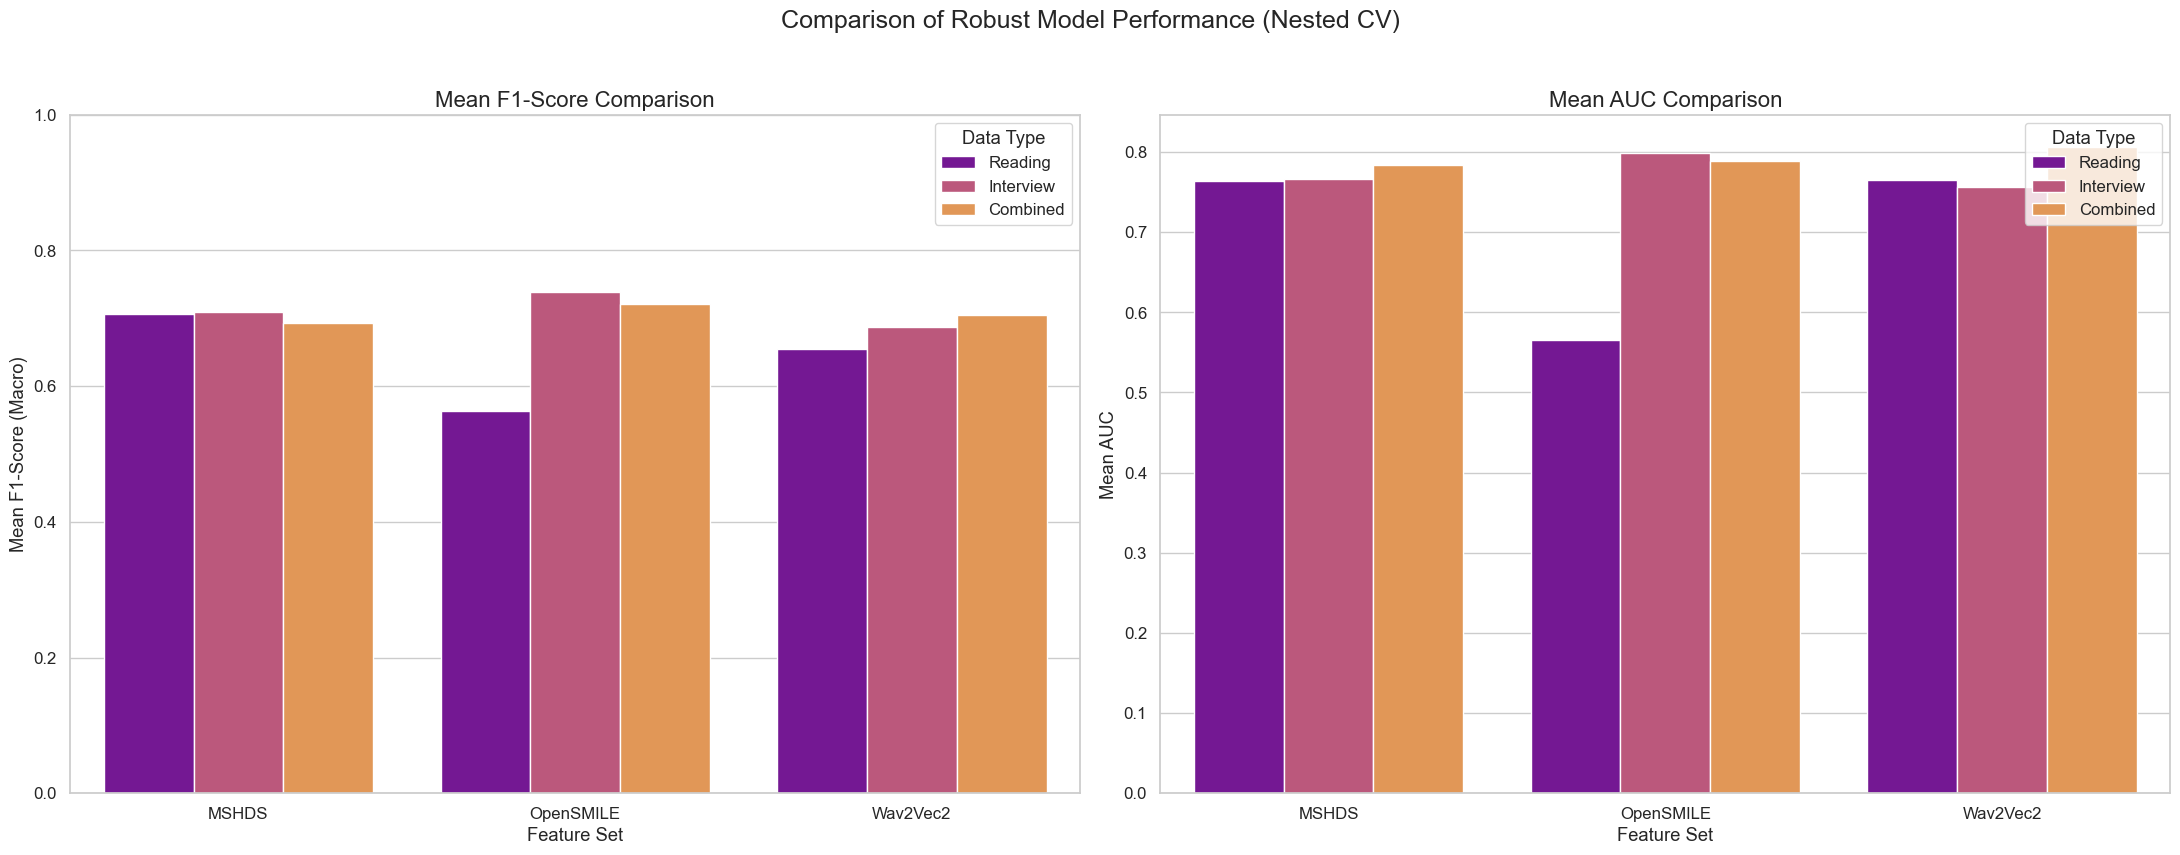

In [ ]:
# Visualize Key Comparisons with Final Side-by-Side Bar Plots

# Prepare the Data

# Select only the robust, nested cross-validation results for the main comparison.
nested_results_df = summary_df[summary_df.index.str.contains('nested')].copy()

# Create new columns for plotting with seaborn
nested_results_df['Data Type'] = [
    'Reading' if 'reading' in idx else 'Interview' if 'interview' in idx else 'Combined' 
    for idx in nested_results_df.index
]
nested_results_df['Feature Set'] = [
    'MSHDS' if 'mshds' in idx else 'OpenSMILE' if 'opensmile' in idx else 'Wav2Vec2'
    for idx in nested_results_df.index
]

# - Create the Figure and Subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 9), sharey=False) # sharey=True is good here
fig.suptitle('Comparison of Robust Model Performance (Nested CV)', fontsize=18)

# - Plot for F1-Score
sns.barplot(
    ax=axes[0],
    data=nested_results_df, 
    x='Feature Set', 
    y='Mean F1-Score', 
    hue='Data Type', 
    palette='plasma'
)
axes[0].set_title('Mean F1-Score Comparison', fontsize=16)
axes[0].set_ylabel('Mean F1-Score (Macro)')
axes[0].set_xlabel('Feature Set')
axes[0].set_ylim(0, 1.0)
axes[0].legend(title='Data Type')

# - Plot for AUC
sns.barplot(
    ax=axes[1],
    data=nested_results_df, 
    x='Feature Set', 
    y='Mean AUC', 
    hue='Data Type', 
    palette='plasma'
)
axes[1].set_title('Mean AUC Comparison', fontsize=16)
axes[1].set_ylabel('Mean AUC')
axes[1].set_xlabel('Feature Set')
axes[1].legend(title='Data Type')

# Finalize and Show Plot 
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_4712\1204893125.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\ayush\AppData\Local\Temp\ipykernel_4712\1204893125.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


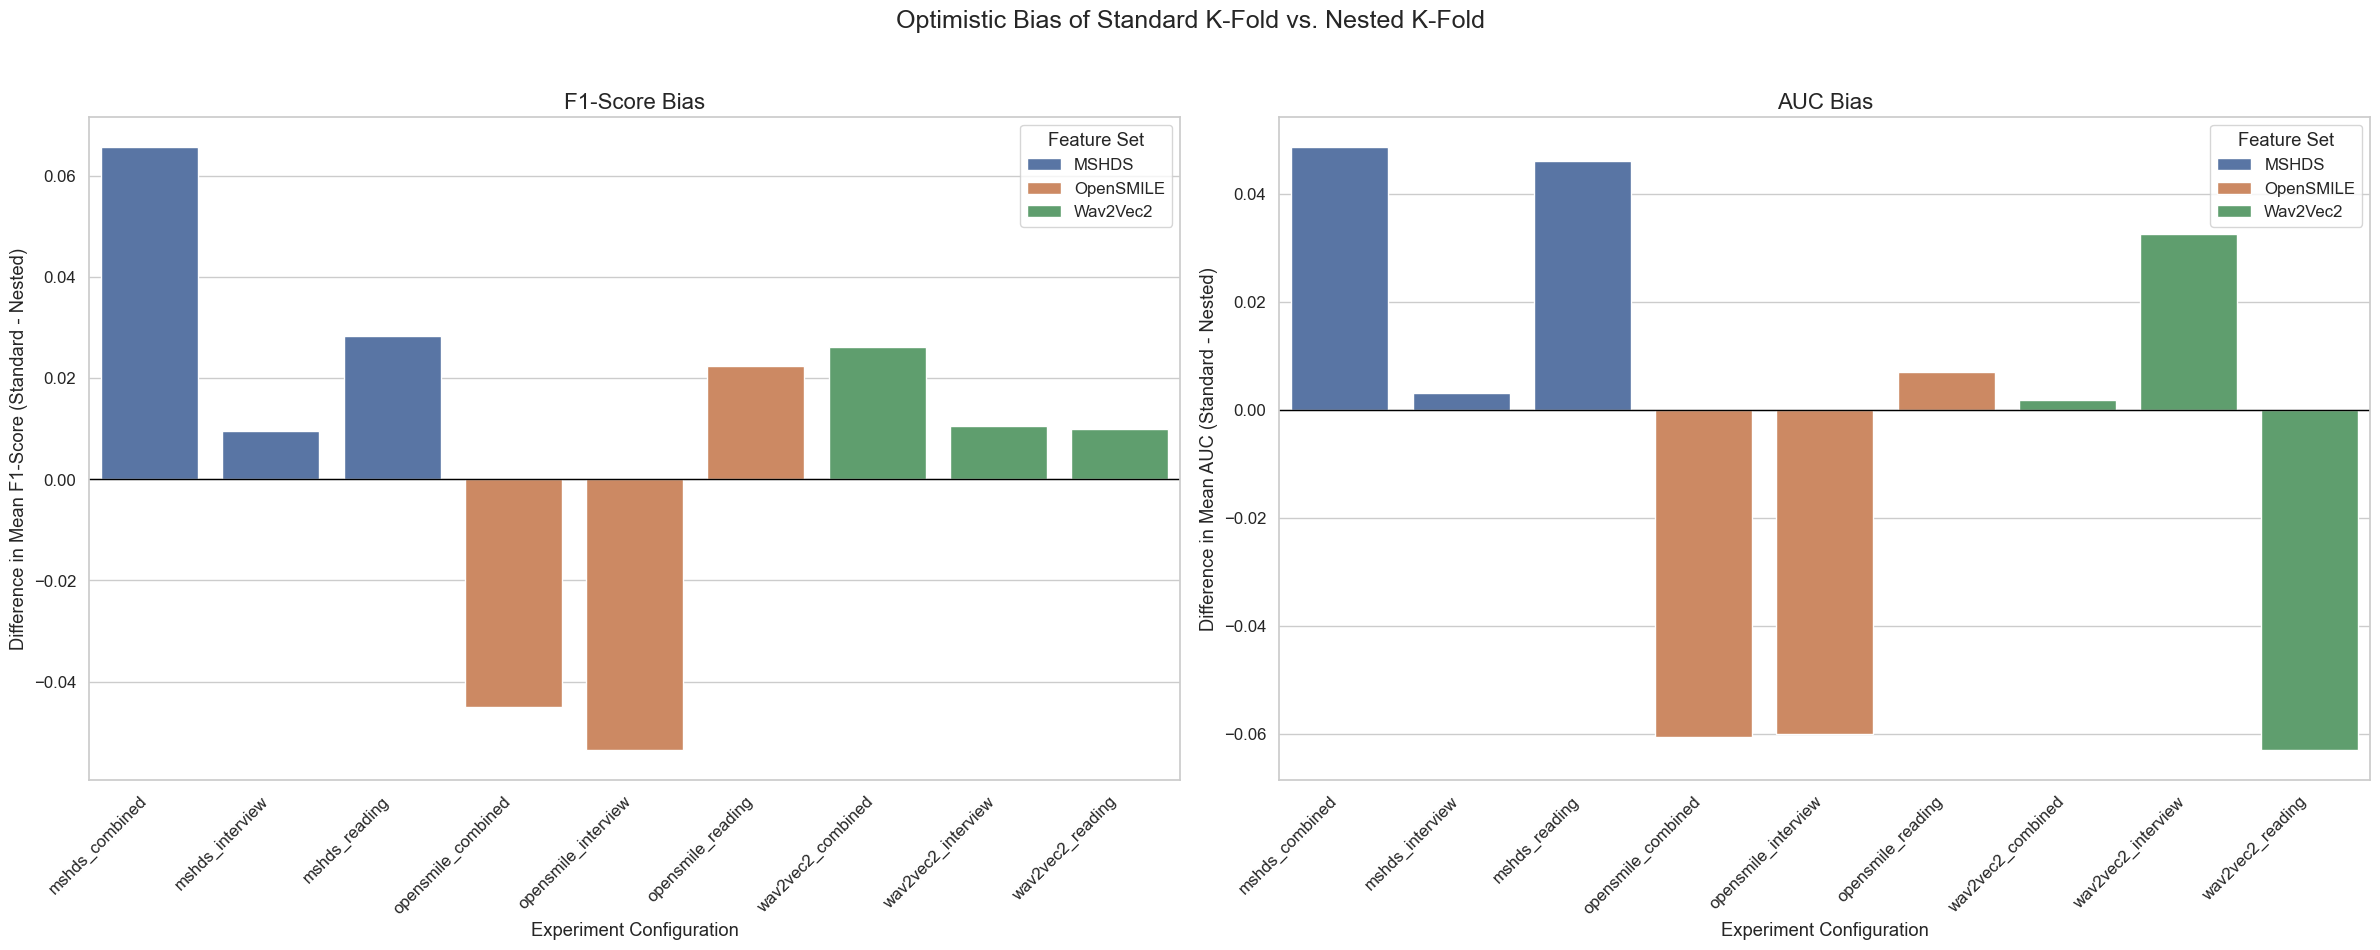

In [ ]:
# Visualize the Optimistic Bias for both F1-Score and AUC 

# Create the Figure and Subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 10), sharey=False) 
fig.suptitle('Optimistic Bias of Standard K-Fold vs. Nested K-Fold', fontsize=18)


# - Plot for F1-Score

# Isolate the F1-scores
f1_scores = summary_df[['Mean F1-Score']].copy()
f1_scores['cv_method'] = ['standard' if 'standard' in idx else 'nested' for idx in f1_scores.index]
f1_scores['experiment_base'] = [idx.replace('_standard', '').replace('_nested', '') for idx in f1_scores.index]

# Pivot the table to get standard and nested scores side-by-side
f1_pivot = f1_scores.pivot_table(index='experiment_base', columns='cv_method', values='Mean F1-Score')

# Calculate the optimistic bias
f1_pivot['optimistic_bias'] = f1_pivot['standard'] - f1_pivot['nested']
f1_pivot.reset_index(inplace=True)

# Add a column for hue
f1_pivot['feature_set'] = [
    'MSHDS' if 'mshds' in idx else 'OpenSMILE' if 'opensmile' in idx else 'Wav2Vec2'
    for idx in f1_pivot['experiment_base']
]

# Create the plot on the first axis (axes[0])
sns.barplot(
    ax=axes[0],
    data=f1_pivot, 
    x='experiment_base', 
    y='optimistic_bias', 
    hue='feature_set', 
    palette='deep',
    dodge=False
)
axes[0].set_title('F1-Score Bias', fontsize=16)
axes[0].set_ylabel('Difference in Mean F1-Score (Standard - Nested)')
axes[0].set_xlabel('Experiment Configuration')
axes[0].axhline(0, color='black', lw=1.0)


# - Plot for AUC

# Isolate the AUC scores
auc_scores = summary_df[['Mean AUC']].copy()
auc_scores['cv_method'] = ['standard' if 'standard' in idx else 'nested' for idx in auc_scores.index]
auc_scores['experiment_base'] = [idx.replace('_standard', '').replace('_nested', '') for idx in auc_scores.index]

# Pivot the table for AUC
auc_pivot = auc_scores.pivot_table(index='experiment_base', columns='cv_method', values='Mean AUC')

# Calculate the optimistic bias for AUC
auc_pivot['optimistic_bias'] = auc_pivot['standard'] - auc_pivot['nested']
auc_pivot.reset_index(inplace=True)

# Add a column for hue
auc_pivot['feature_set'] = [
    'MSHDS' if 'mshds' in idx else 'OpenSMILE' if 'opensmile' in idx else 'Wav2Vec2'
    for idx in auc_pivot['experiment_base']
]

# Create the plot on the second axis (axes[1])
sns.barplot(
    ax=axes[1],
    data=auc_pivot, 
    x='experiment_base', 
    y='optimistic_bias', 
    hue='feature_set', 
    palette='deep',
    dodge=False
)
axes[1].set_title('AUC Bias', fontsize=16)
axes[1].set_ylabel('Difference in Mean AUC (Standard - Nested)')
axes[1].set_xlabel('Experiment Configuration')
axes[1].axhline(0, color='black', lw=1.0)


# Finalize and Show Plot
# Clean up the x-axis labels for both subplots
for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.get_legend().set_title('Feature Set')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

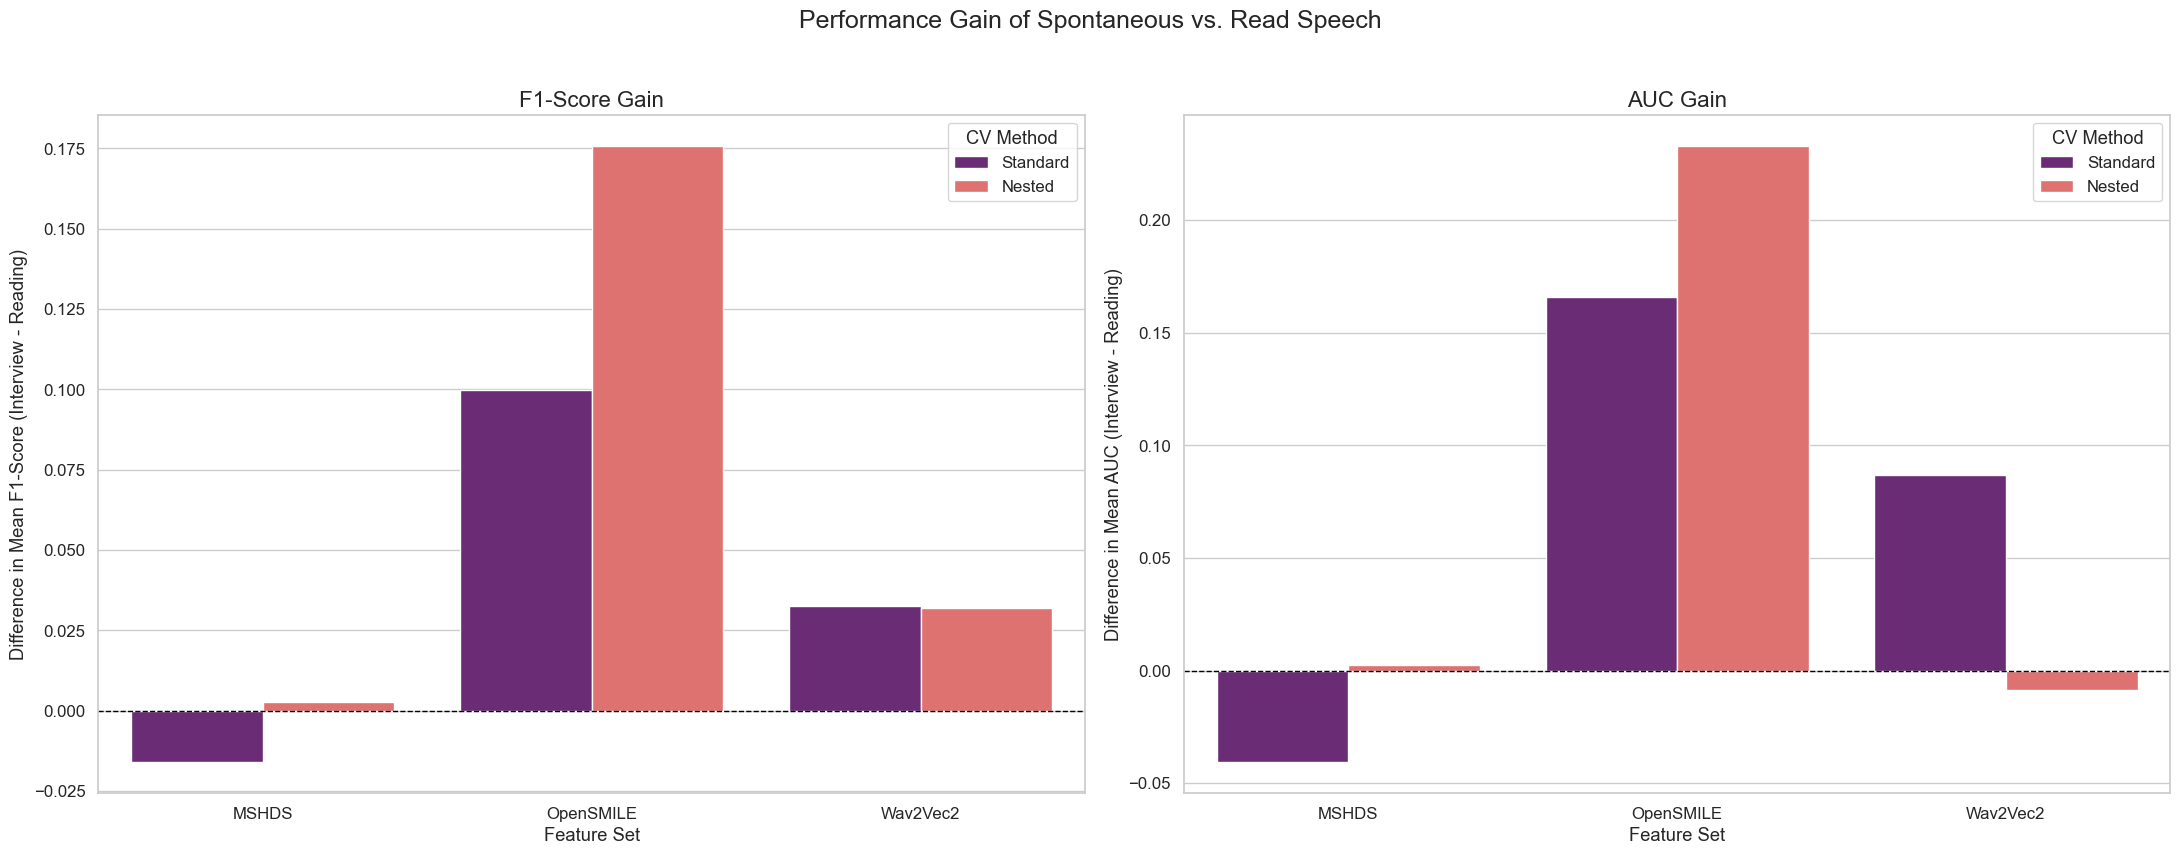

In [ ]:
# Visualize Performance Gain of Interview vs. Reading Data

# Prepare the Data 

# Filter out the 'combined' results to focus on the task comparison
task_comparison_df = summary_df[~summary_df.index.str.contains('combined')].copy()

# Create new columns for plotting
task_comparison_df['cv_method'] = ['Standard' if 'standard' in idx else 'Nested' for idx in task_comparison_df.index]
task_comparison_df['feature_set'] = [
    'MSHDS' if 'mshds' in idx else 'OpenSMILE' if 'opensmile' in idx else 'Wav2Vec2'
    for idx in task_comparison_df.index
]
task_comparison_df['data_type'] = ['Reading' if 'reading' in idx else 'Interview' for idx in task_comparison_df.index]


# Create the Figure and Subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 9))
fig.suptitle('Performance Gain of Spontaneous vs. Read Speech', fontsize=18)


# - Plot for F1-Score 

# Reshape the data to get Reading and Interview scores on the same row
f1_pivot = task_comparison_df.pivot_table(
    index=['feature_set', 'cv_method'], 
    columns='data_type', 
    values='Mean F1-Score'
).reset_index()

# Calculate the performance gain (or loss)
f1_pivot['performance_gain'] = f1_pivot['Interview'] - f1_pivot['Reading']

# Create the bar plot on the first axis
sns.barplot(
    ax=axes[0],
    data=f1_pivot, 
    x='feature_set', 
    y='performance_gain', 
    hue='cv_method', 
    palette='magma',
    hue_order=['Standard', 'Nested'] 
)
axes[0].set_title('F1-Score Gain', fontsize=16)
axes[0].set_ylabel('Difference in Mean F1-Score (Interview - Reading)')
axes[0].set_xlabel('Feature Set')
axes[0].axhline(0, color='black', lw=1.0, linestyle='--')
axes[0].legend(title='CV Method')


# - Plot for AUC 

# Reshape the data for AUC scores
auc_pivot = task_comparison_df.pivot_table(
    index=['feature_set', 'cv_method'], 
    columns='data_type', 
    values='Mean AUC'
).reset_index()

# Calculate the performance gain for AUC
auc_pivot['performance_gain'] = auc_pivot['Interview'] - auc_pivot['Reading']

# Create the bar plot on the second axis
sns.barplot(
    ax=axes[1],
    data=auc_pivot, 
    x='feature_set', 
    y='performance_gain', 
    hue='cv_method',
    
    # Use the same 'magma' palette for color consistency
    palette='magma',
    hue_order=['Standard', 'Nested']
)
axes[1].set_title('AUC Gain', fontsize=16)
axes[1].set_ylabel('Difference in Mean AUC (Interview - Reading)')
axes[1].set_xlabel('Feature Set')
axes[1].axhline(0, color='black', lw=1.0, linestyle='--')
axes[1].legend(title='CV Method')


# Finalize and Show Plot
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

--- Generating Final Box Plots for F1-Score and AUC Distribution ---


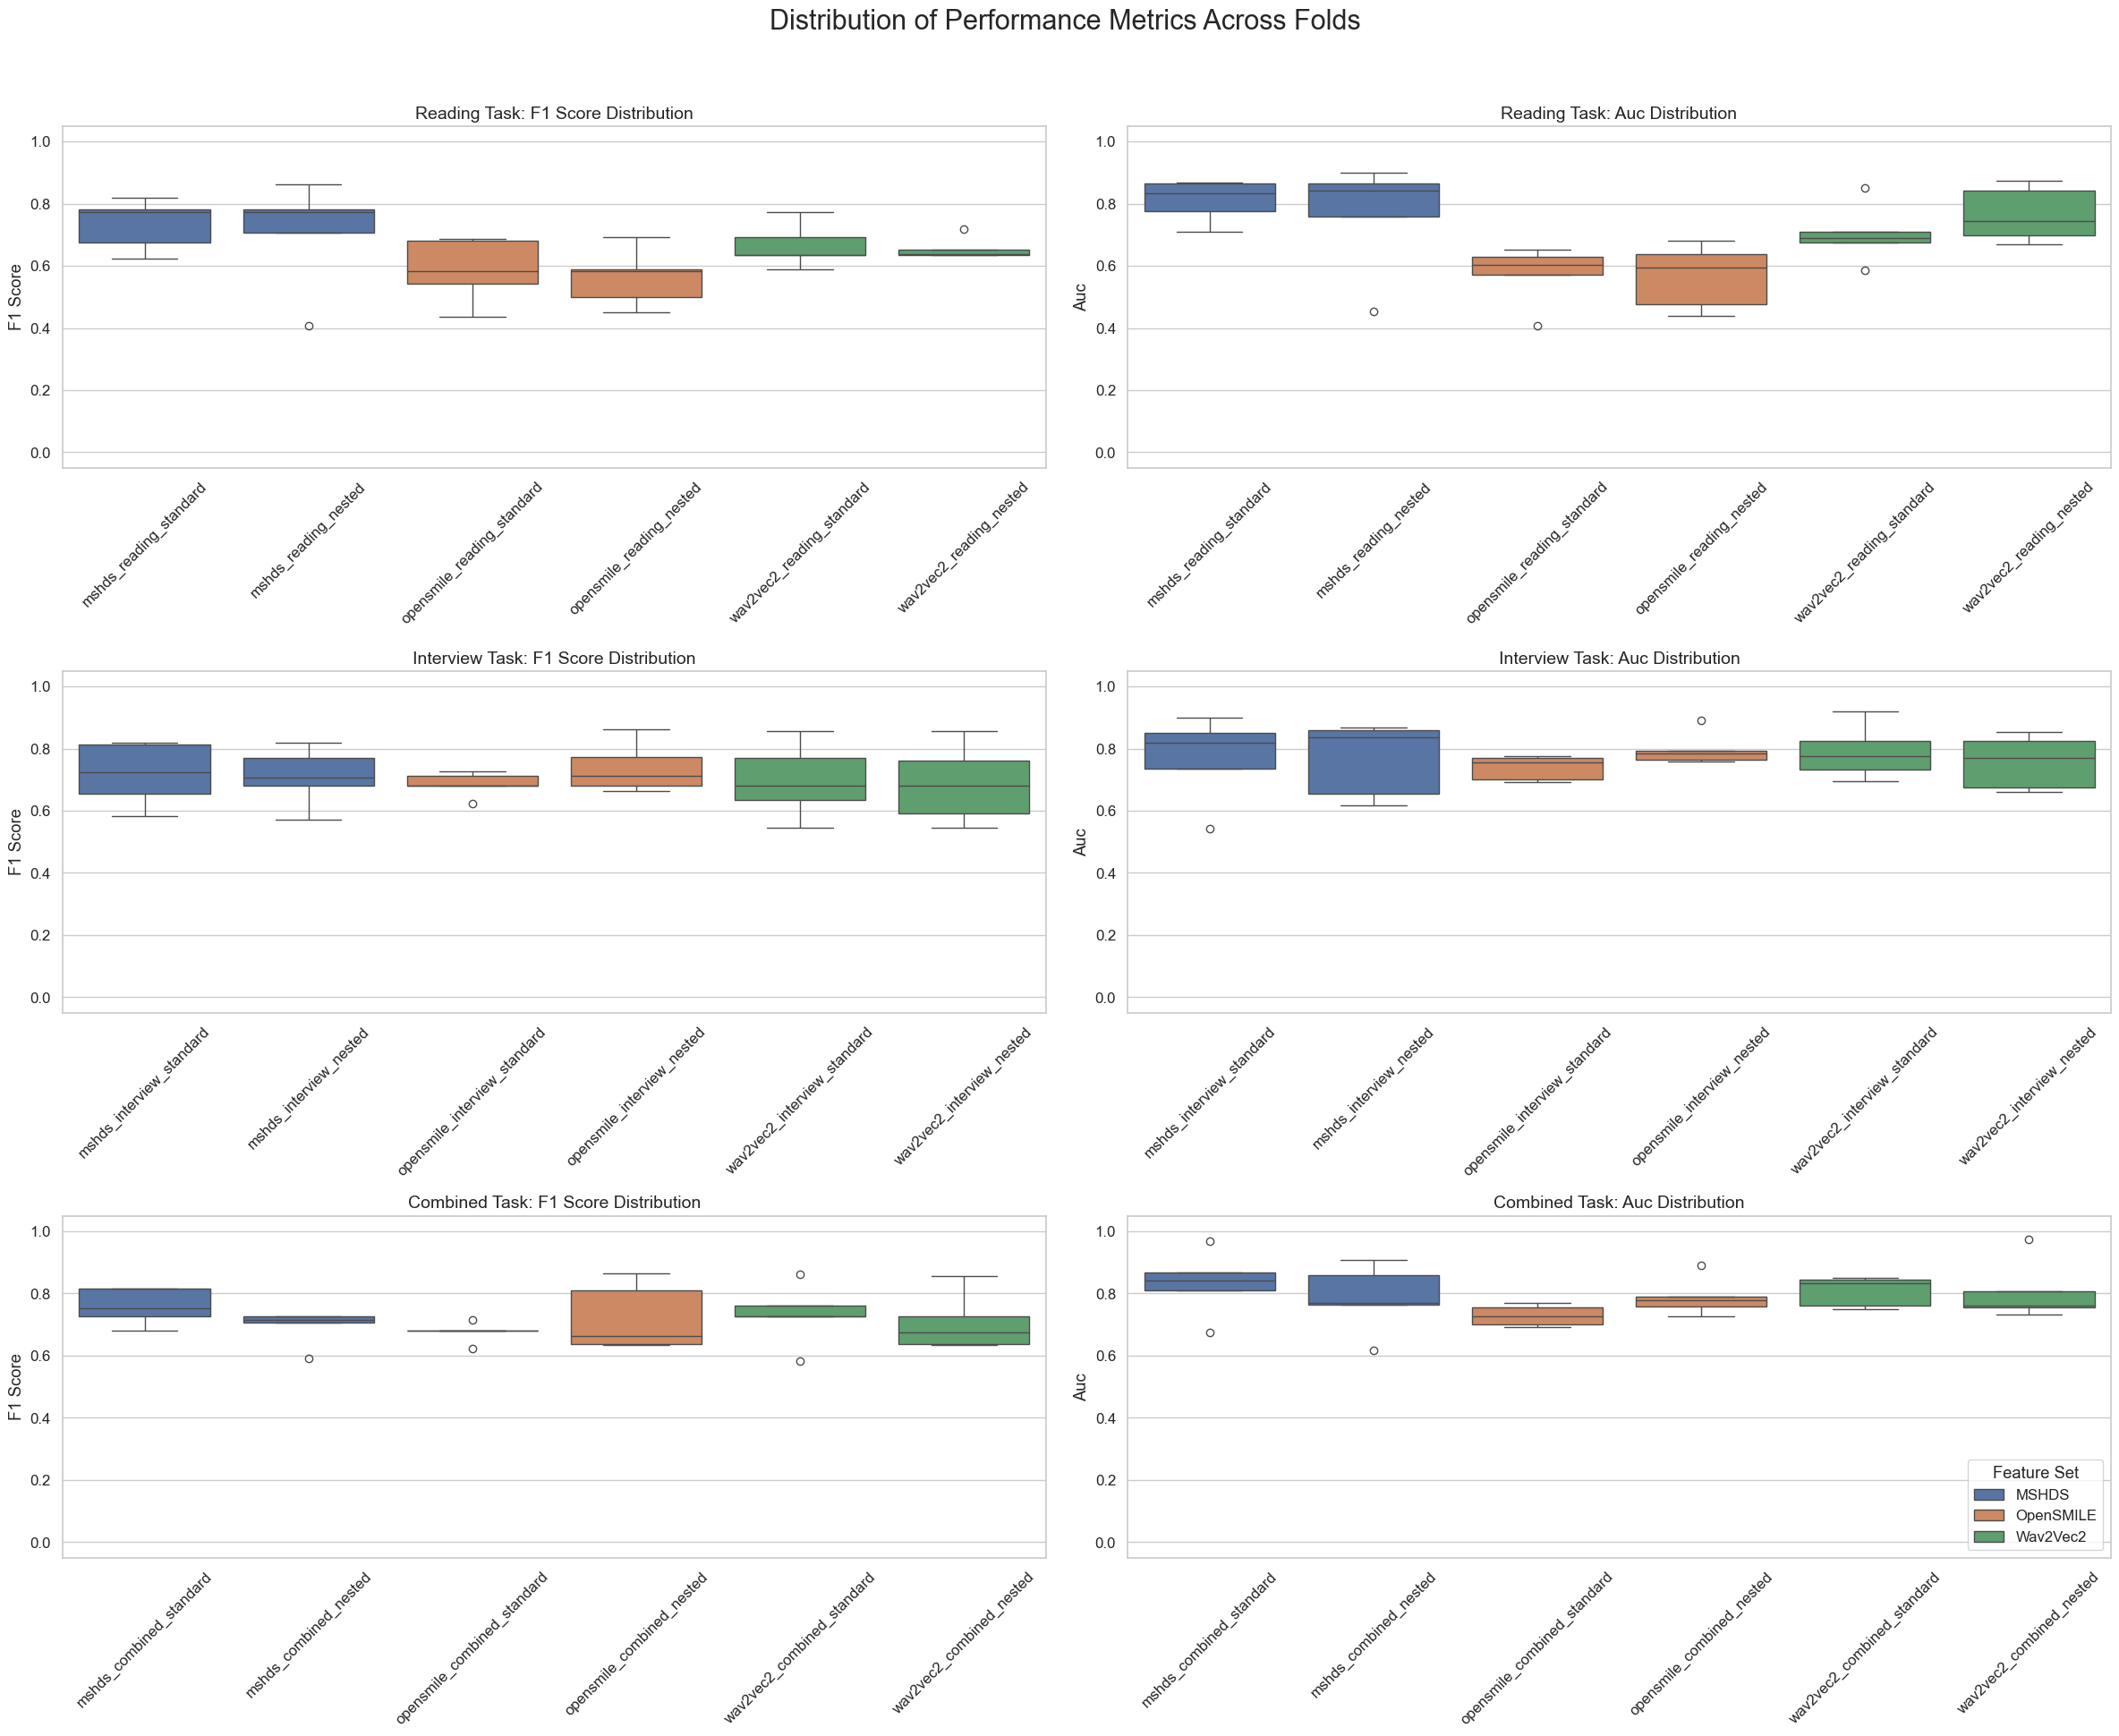

In [ ]:
# Visualize Score Distribution with Final Themed Box Plots 

print("--- Generating Final Box Plots for F1-Score and AUC Distribution ---")

# Prepare the "long-form" DataFrame suitable for Seaborn.
# This combines the results from all 18 experiments into one table.
all_fold_results = []
for experiment_name, data in all_results.items():
    # Make a copy to avoid modifying the original results
    df = data['results_df'].copy()
    df['experiment'] = experiment_name
    all_fold_results.append(df)

long_form_df = pd.concat(all_fold_results, ignore_index=True)

# The 'long_form_df' DataFrame should already exist.
# Create the columns for hue and data type.
if 'feature_set' not in long_form_df.columns:
    long_form_df['feature_set'] = [
        'MSHDS' if 'mshds' in idx else 'OpenSMILE' if 'opensmile' in idx else 'Wav2Vec2'
        for idx in long_form_df['experiment']
    ]
if 'data_type' not in long_form_df.columns:
    long_form_df['data_type'] = [
        'Reading' if 'reading' in idx else 'Interview' if 'interview' in idx else 'Combined'
        for idx in long_form_df['experiment']
    ]

# Create the 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(24, 20), sharey=False)

fig.suptitle('Distribution of Performance Metrics Across Folds', fontsize=22, y=1.0)

# Define the data types, metrics, and a color palette for the feature sets
data_types = ['Reading', 'Interview', 'Combined']
metrics_to_plot = ['f1_score', 'auc']
feature_palette = {"MSHDS": "C0", "OpenSMILE": "C1", "Wav2Vec2": "C2"} # Consistent colors

# Loop through each row and column to create the plots
for row_idx, data_type in enumerate(data_types):
    for col_idx, metric in enumerate(metrics_to_plot):
        # Select the correct subplot axis
        ax = axes[row_idx, col_idx]
        
        # Filter the DataFrame for the current data type
        plot_df = long_form_df[long_form_df['data_type'] == data_type]
        
        # Create the box plot with hue based on the feature set
        sns.boxplot(
            ax=ax,
            data=plot_df,
            x='experiment',
            y=metric,
            hue='feature_set',
            palette=feature_palette,
            dodge=False # Keeps the boxes aligned under their labels
        )
        
        # Set titles and labels for clarity
        metric_name = metric.replace('_', ' ').title()
        ax.set_title(f'{data_type} Task: {metric_name} Distribution', fontsize=14)
        ax.set_ylabel(metric_name)
        ax.set_xlabel(None) # Remove the redundant "Experiment" label
        ax.set_ylim(-0.05, 1.05)
        ax.tick_params(axis='x', rotation=45)
        
        # Handle Legends
        # Only show the legend on bottom right plot
        if not (row_idx == 2 and col_idx == 1):
            ax.get_legend().remove()
        else:
            ax.legend(title='Feature Set')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

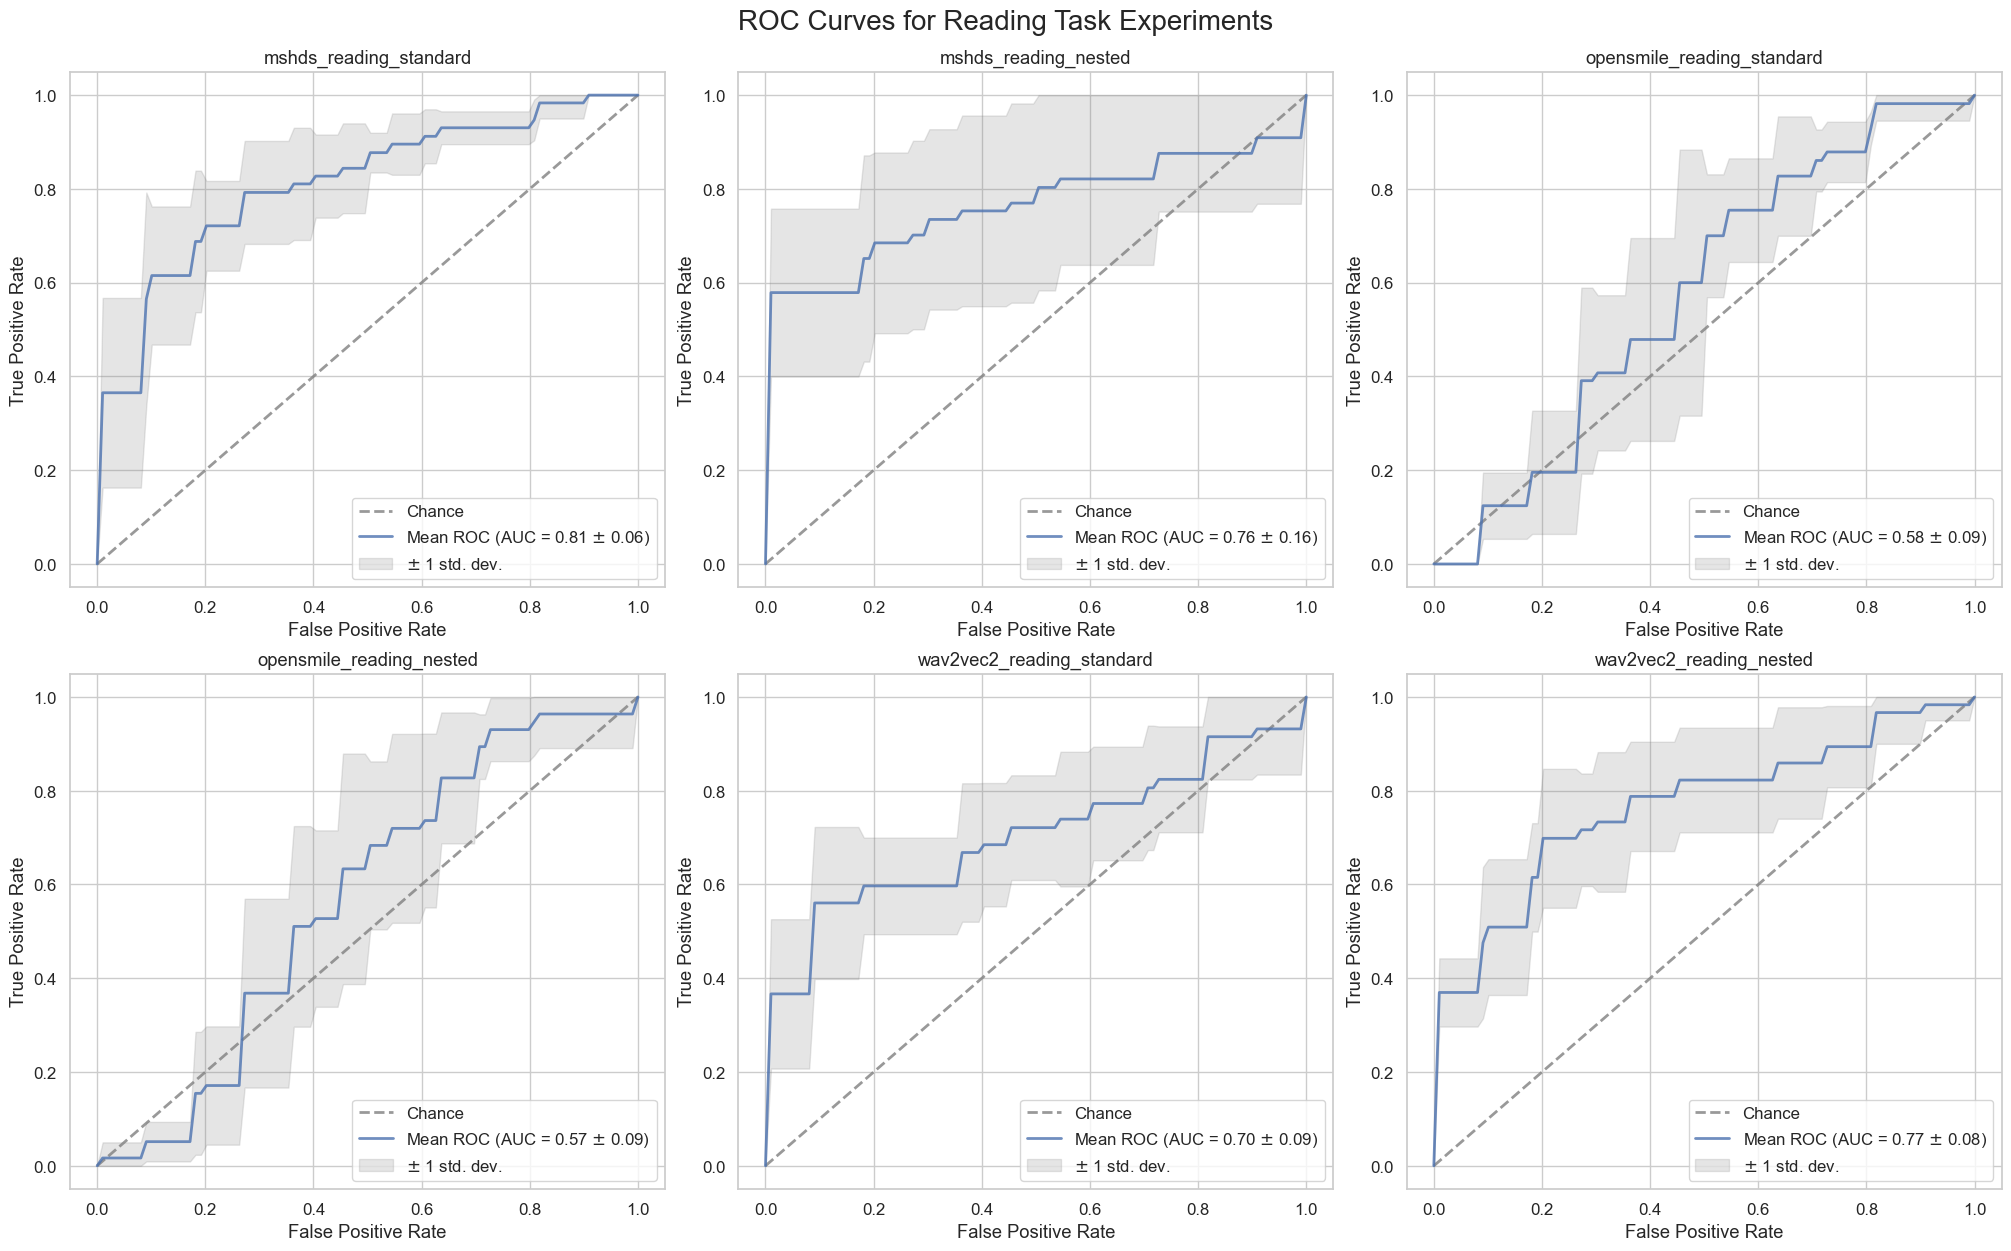

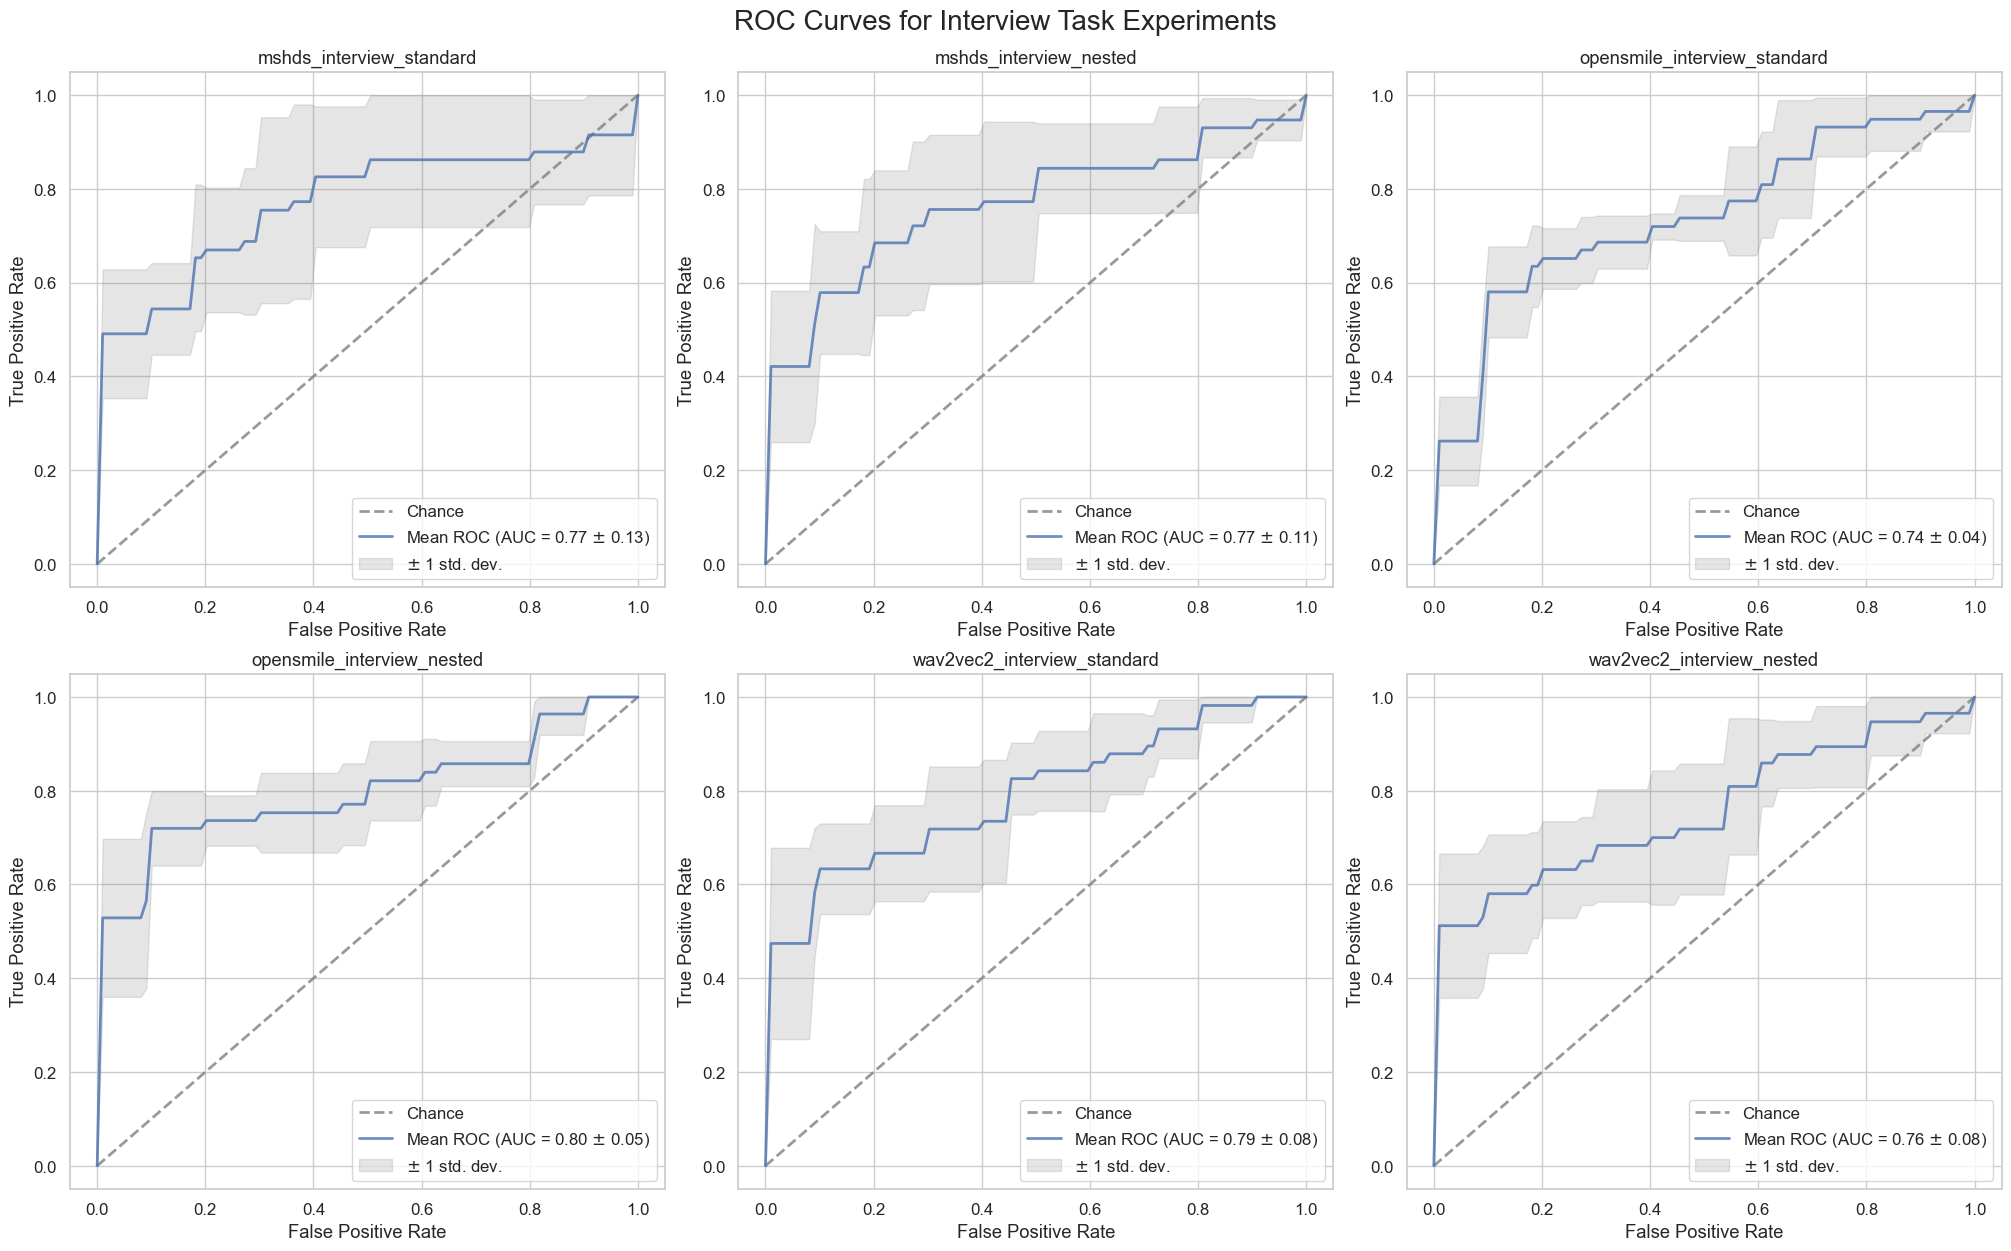

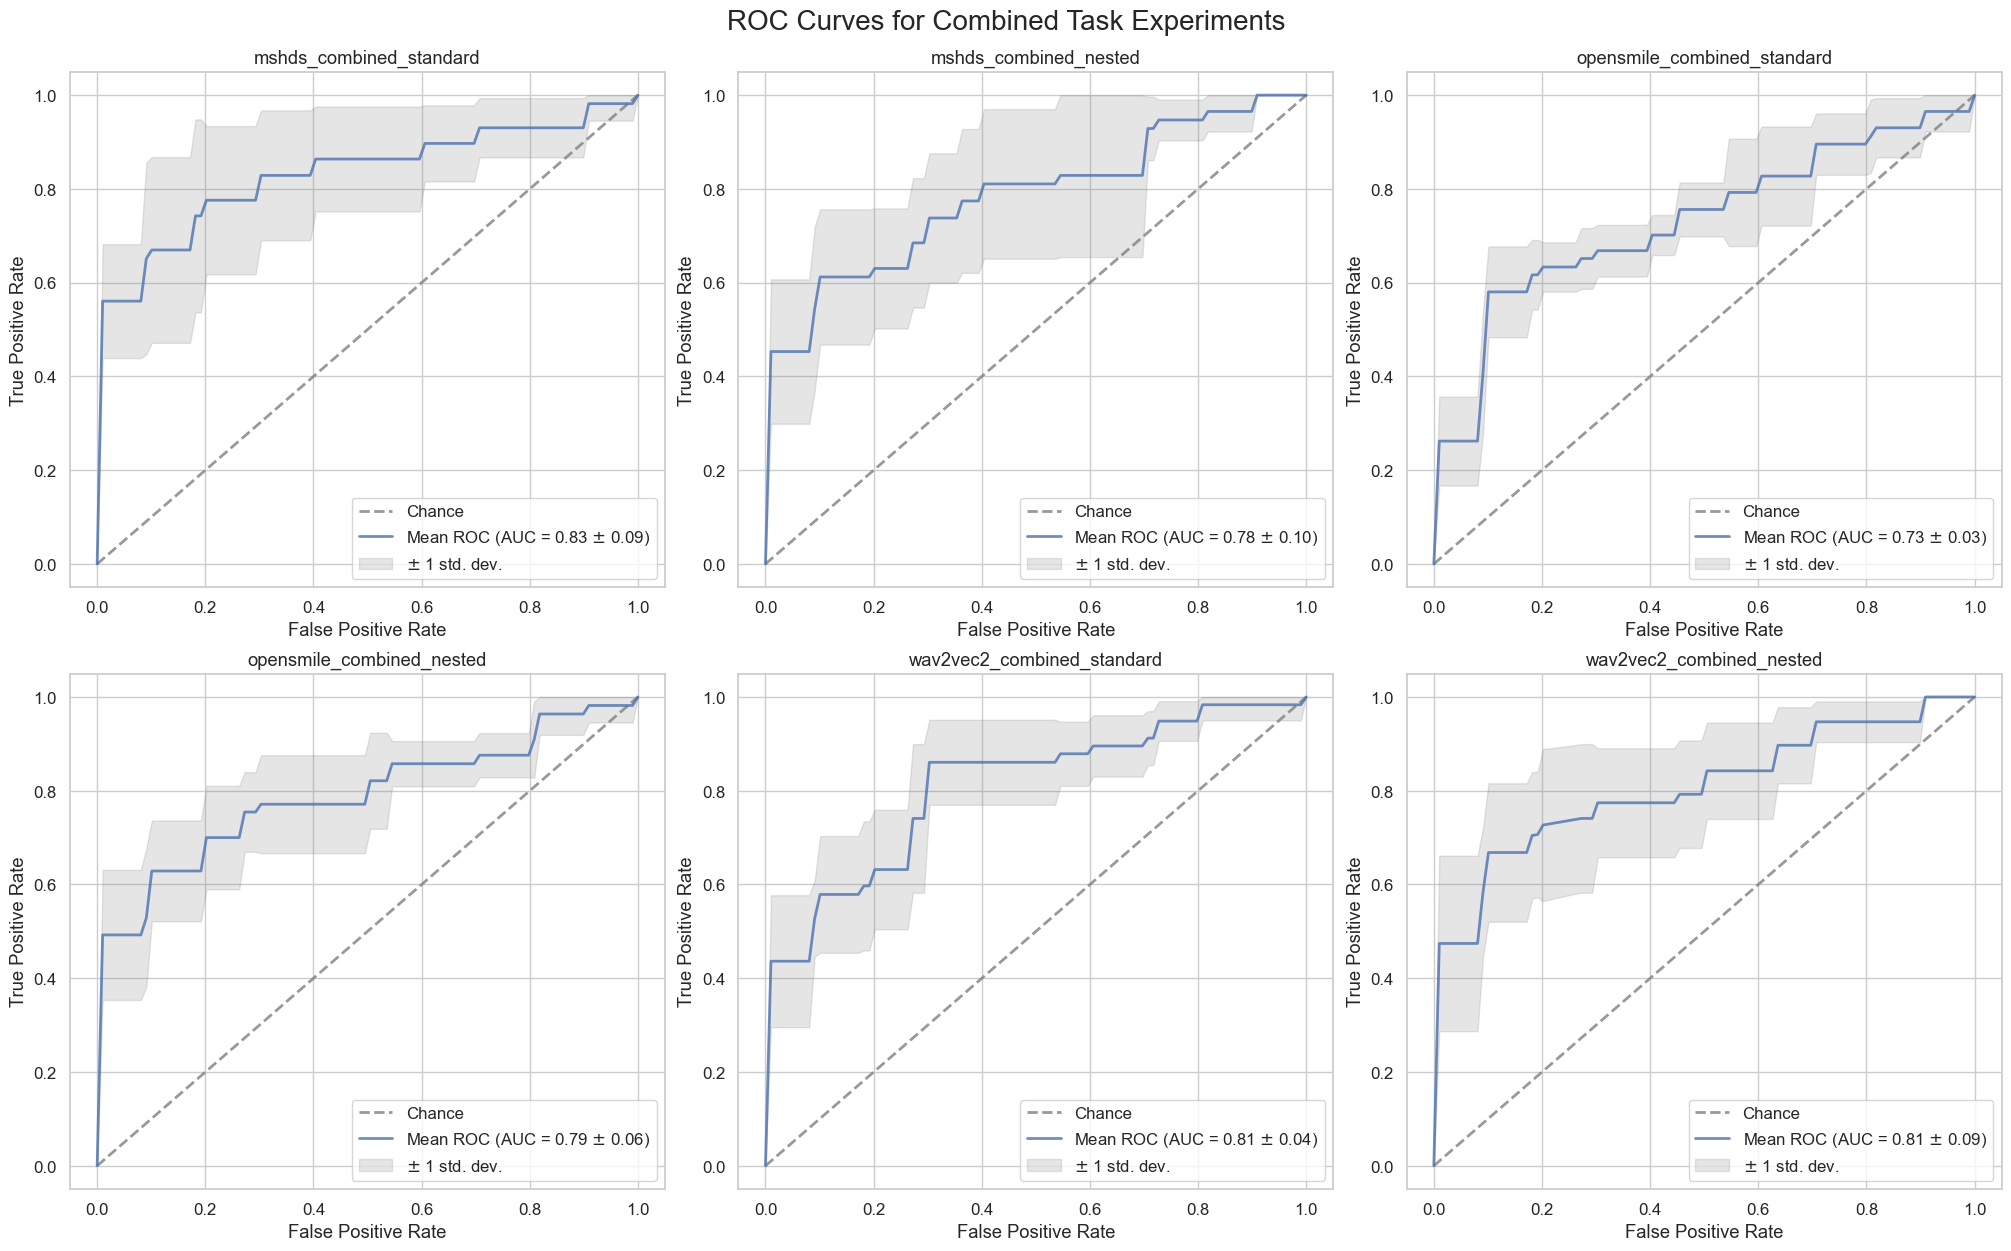

In [ ]:
# Visualize ROC Curves with Separated Plots

# Define the data types to plot
data_types = ['reading', 'interview', 'combined']

# Loop through each data type and create a separate figure for it
for data_type in data_types:
    
    # Filter the results dictionary for the current data type
    filtered_experiments = {k: v for k, v in all_results.items() if data_type in k}
    
    # Create a 2x3 grid of subplots for the 6 experiments of this data type
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), constrained_layout=True)
    axes = axes.ravel() # Flatten the 2x3 grid into a 1D array

    fig.suptitle(f'ROC Curves for {data_type.title()} Task Experiments', fontsize=20, y=1.03)

    # Enumerate through the filtered experiments to plot them
    for i, (experiment_name, data) in enumerate(filtered_experiments.items()):
        ax = axes[i]
        tprs, aucs = [], []
        mean_fpr = np.linspace(0, 1, 100)
        
        # Plot the ROC curve for each of the 5 folds
        for fold_data in data['predictions']:
            fpr, tpr, _ = roc_curve(fold_data['y_true'], fold_data['y_prob'])
            # Interpolate the TPR to a common FPR axis for averaging
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(auc(fpr, tpr))
        
        # Plot the line for random chance
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=.8)
        
        # Calculate and plot the mean ROC curve
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0 # Ensure the curve goes to the top-right corner
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='b', 
                label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', 
                lw=2, alpha=.8)
        
        # Plot the standard deviation area
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, 
                        label=r'$\pm$ 1 std. dev.')

        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
               title=f"{experiment_name}",
               xlabel="False Positive Rate",
               ylabel="True Positive Rate")
        ax.legend(loc="lower right")

    # Turn off any subplots that are not used
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


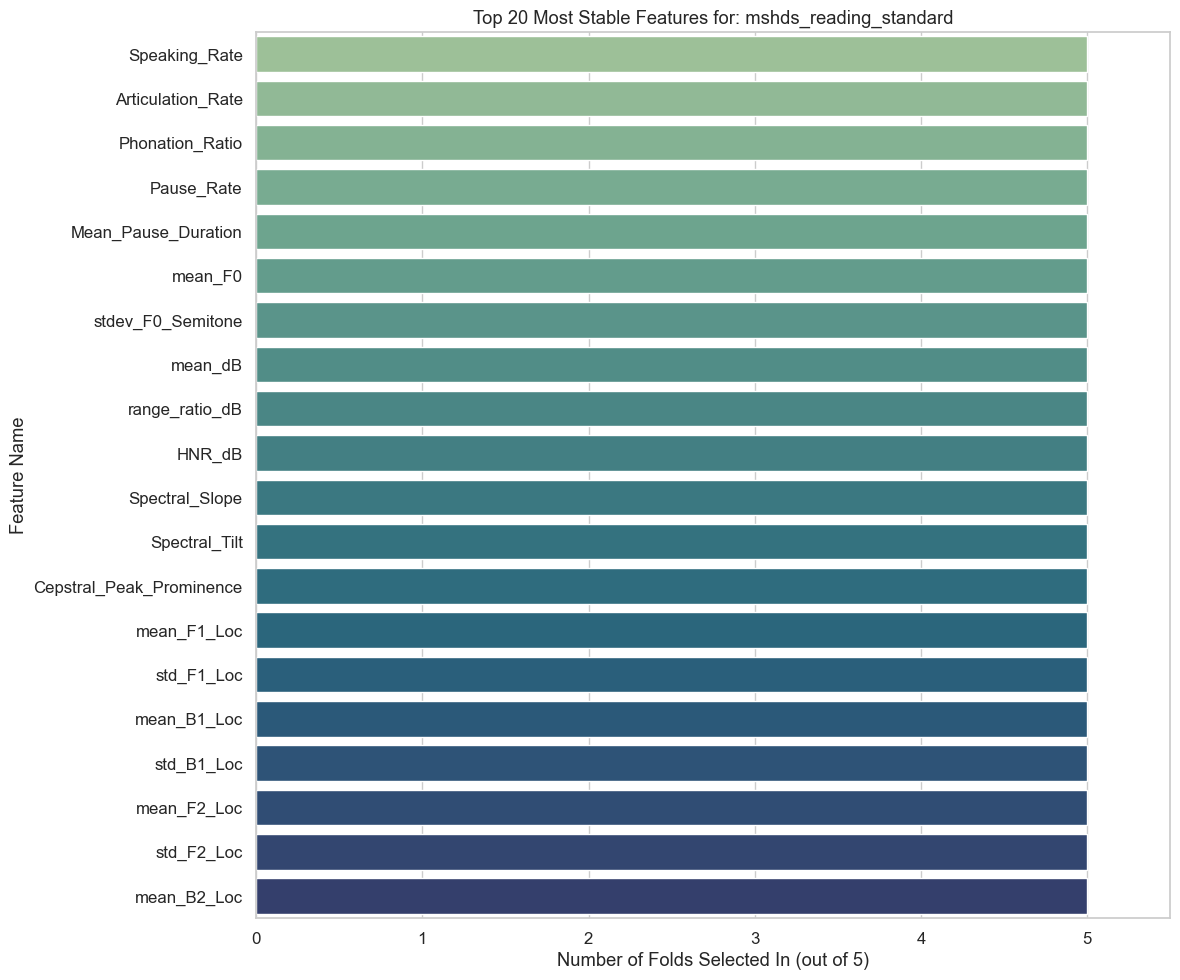

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


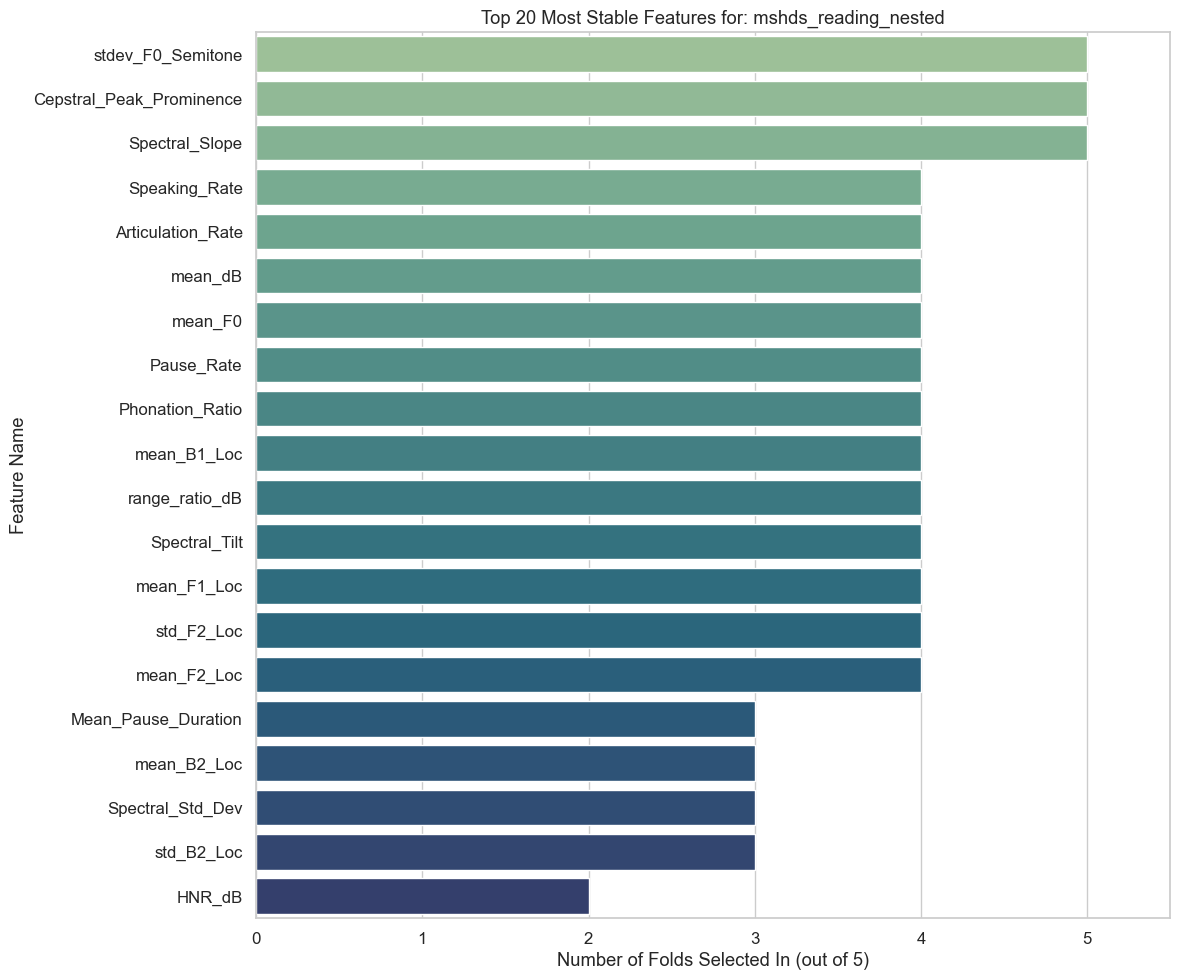

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


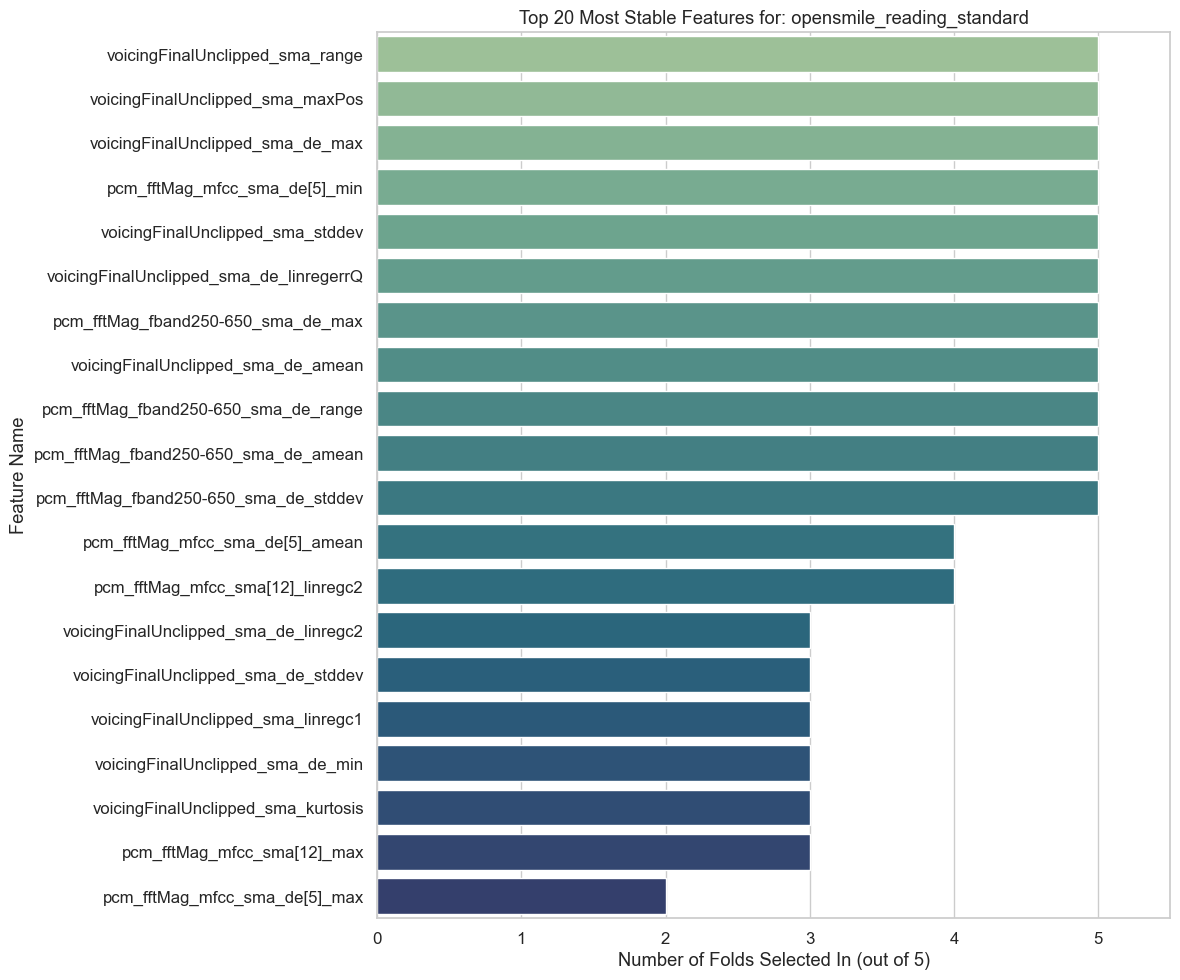

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


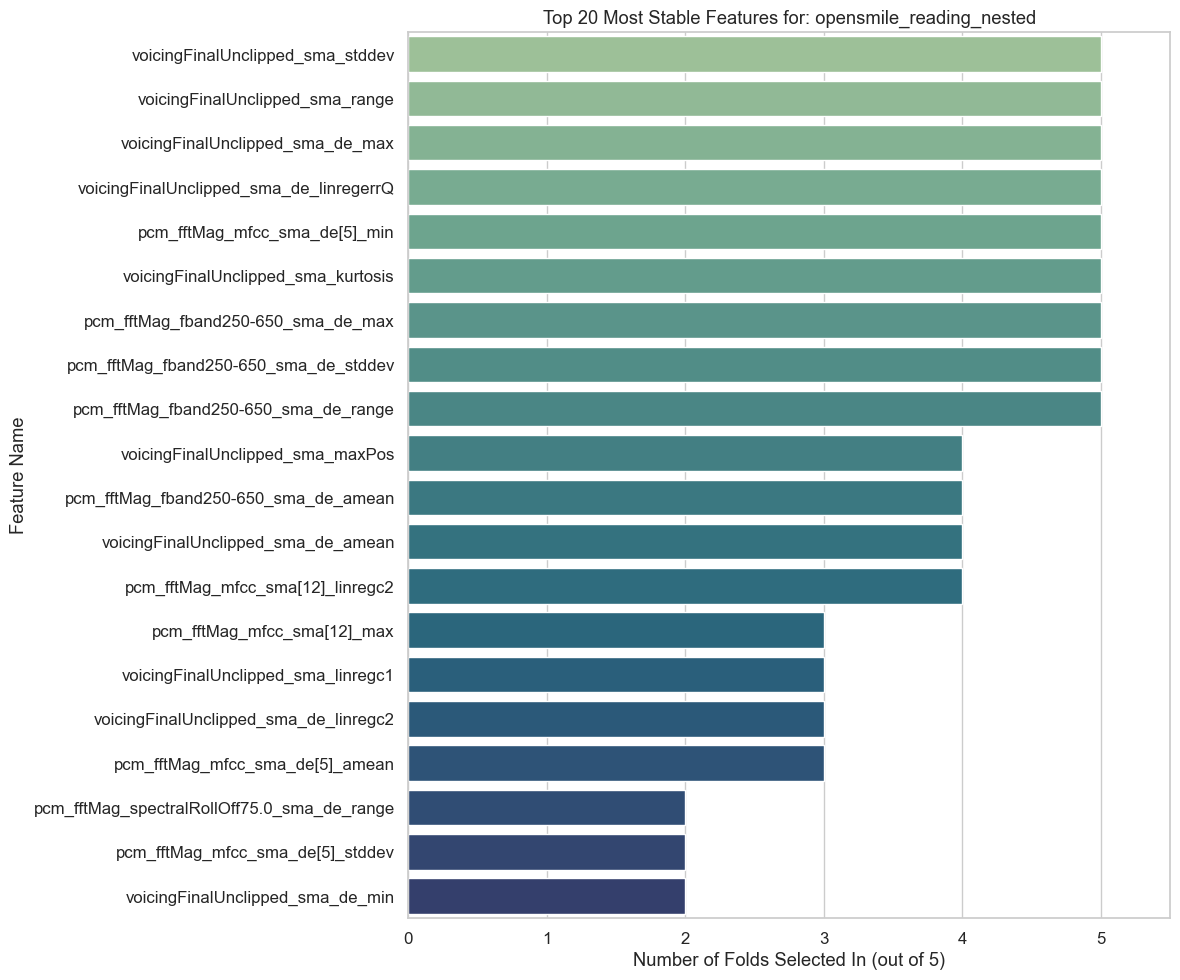

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


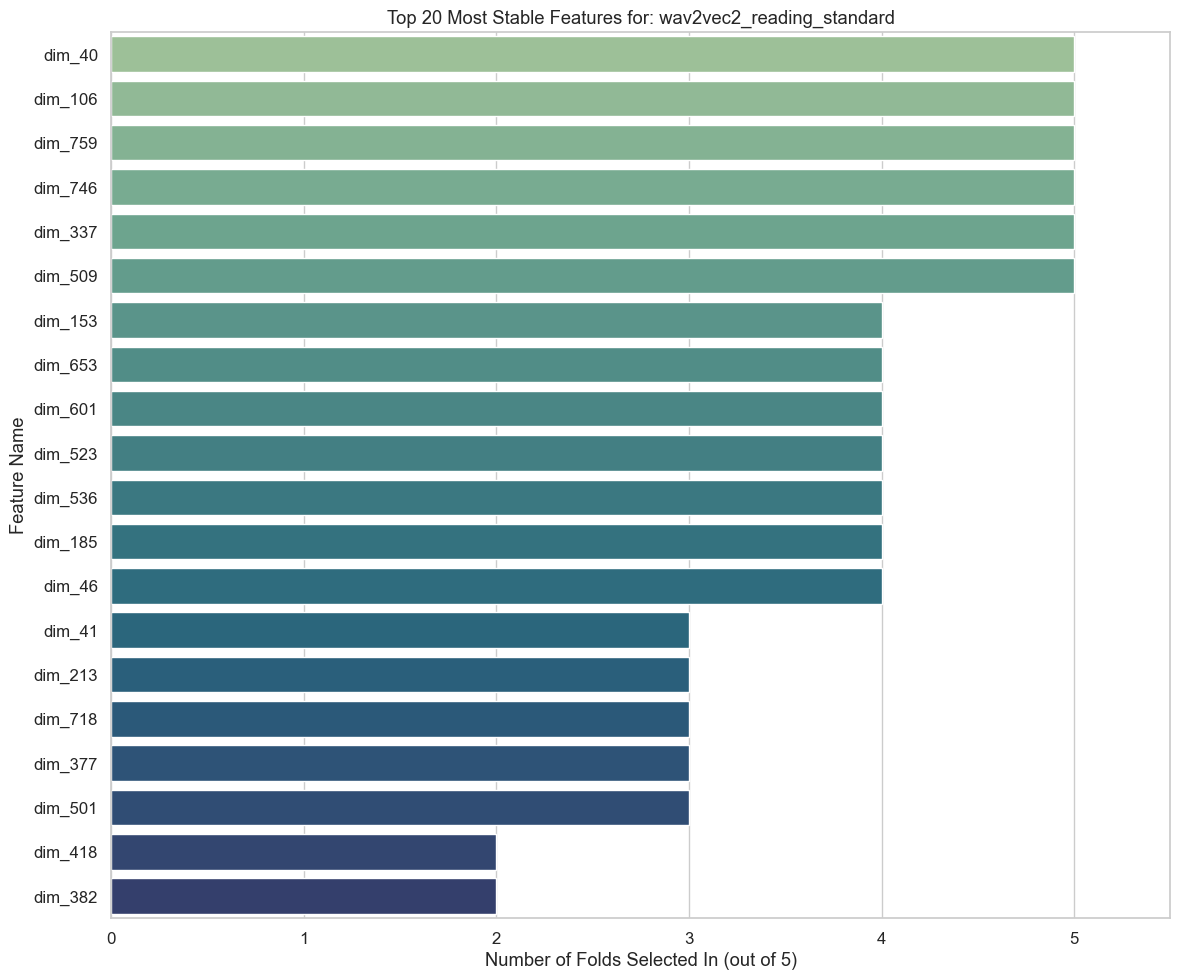

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


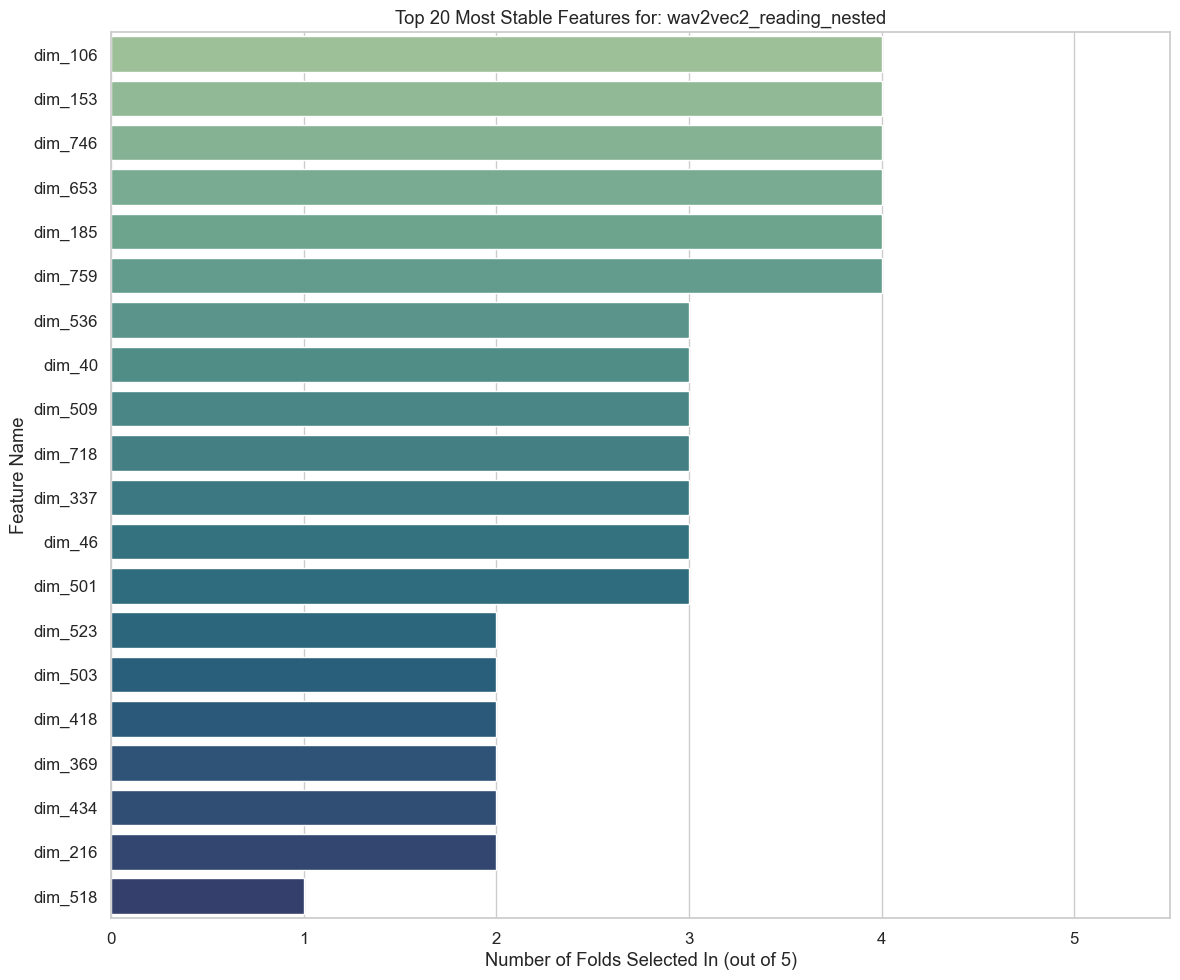

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


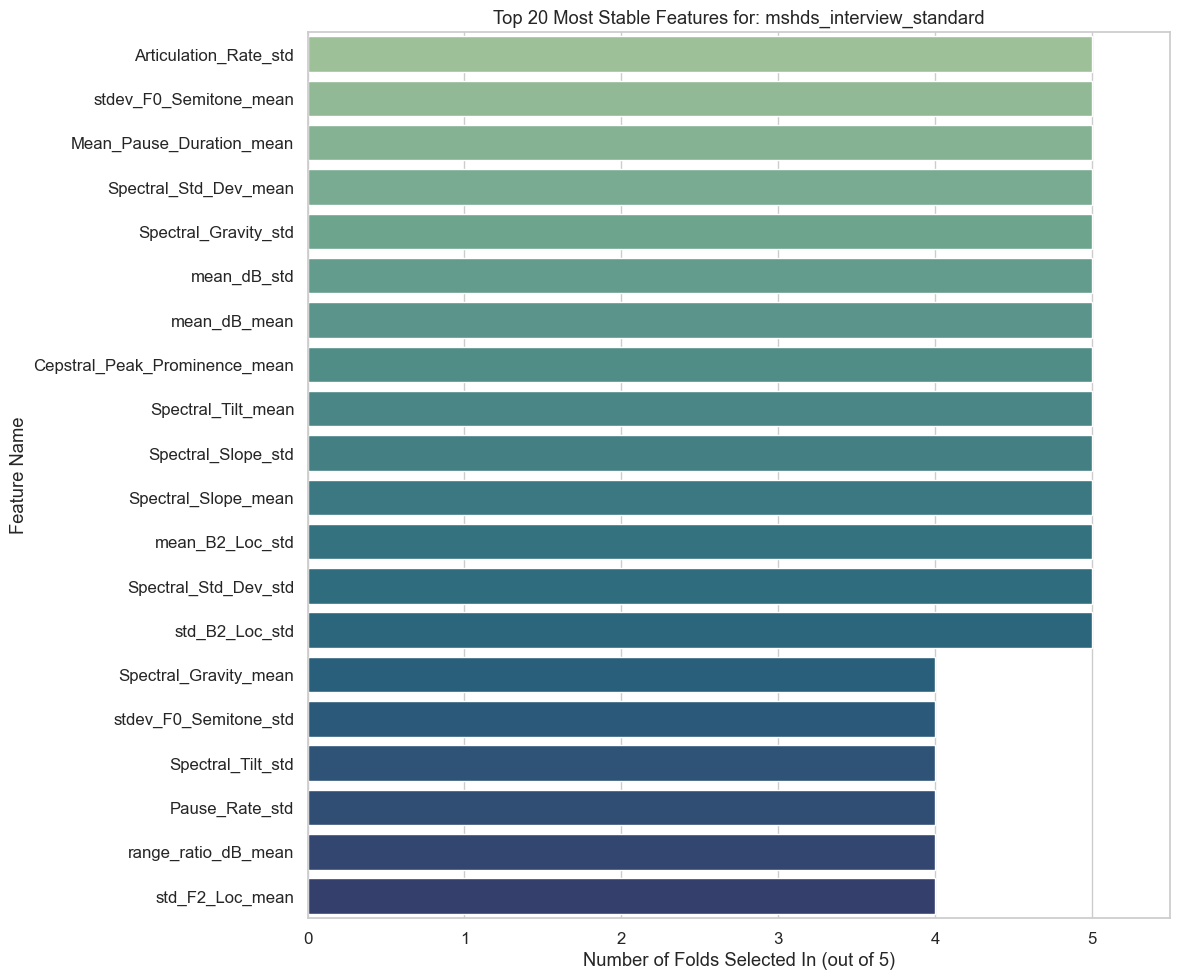

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


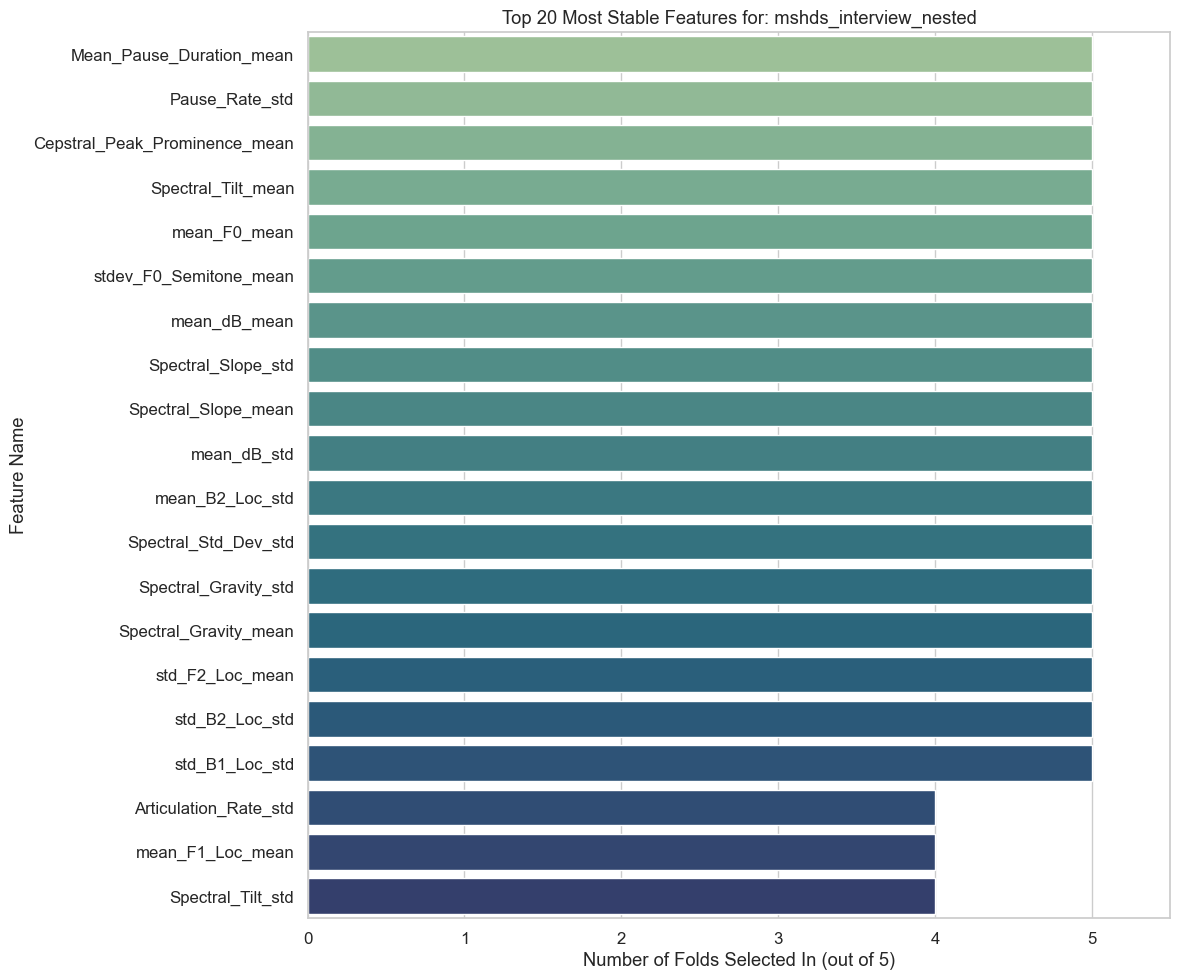

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


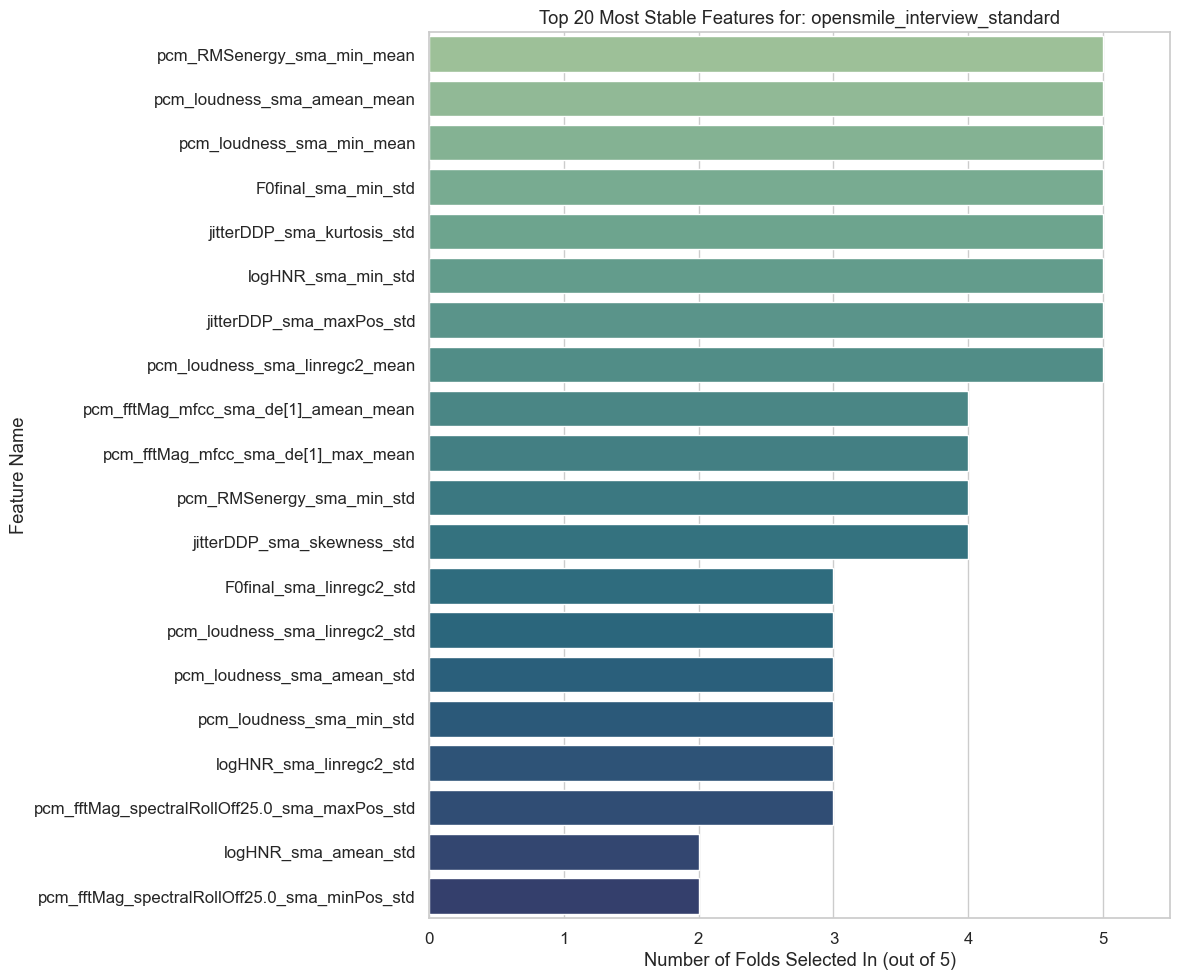

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


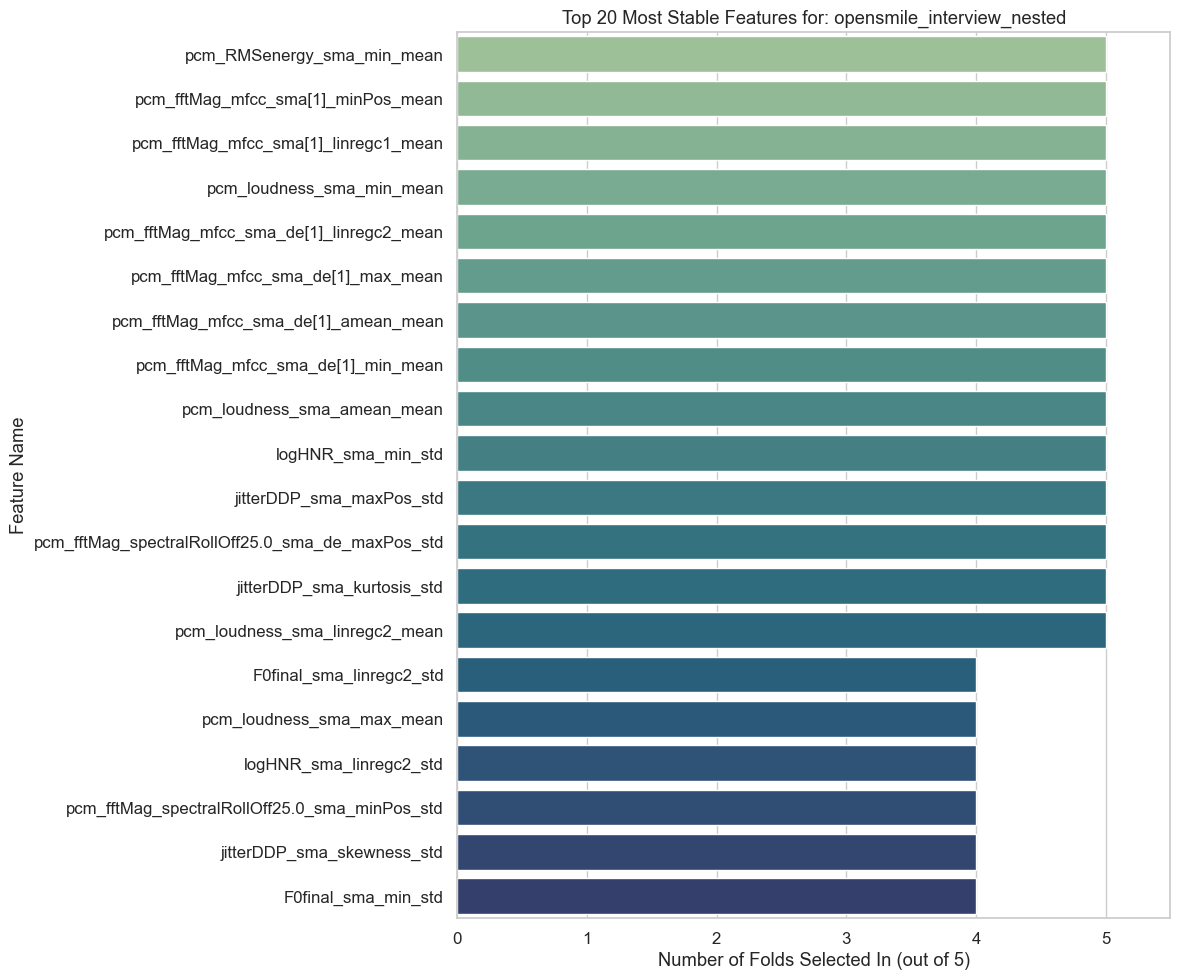

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


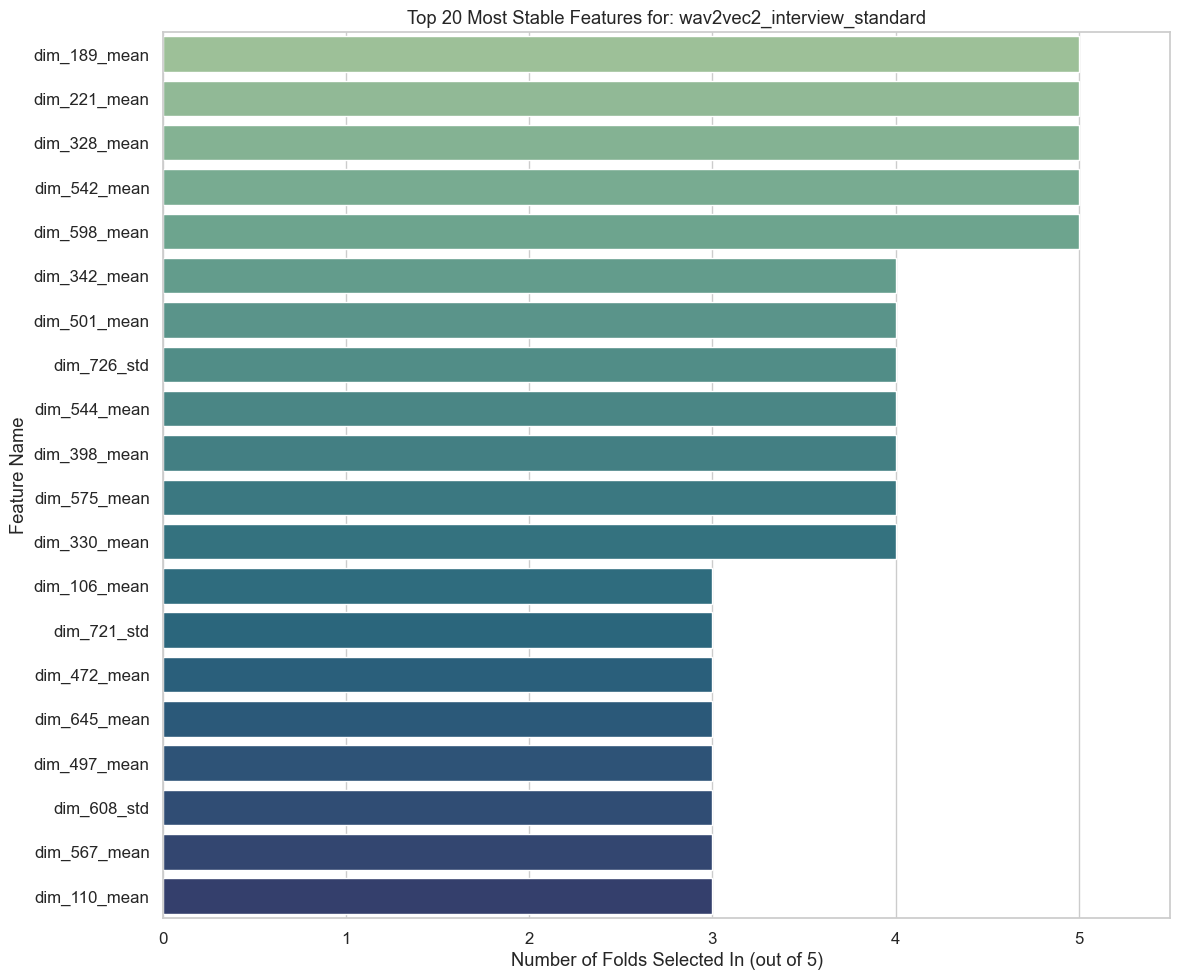

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


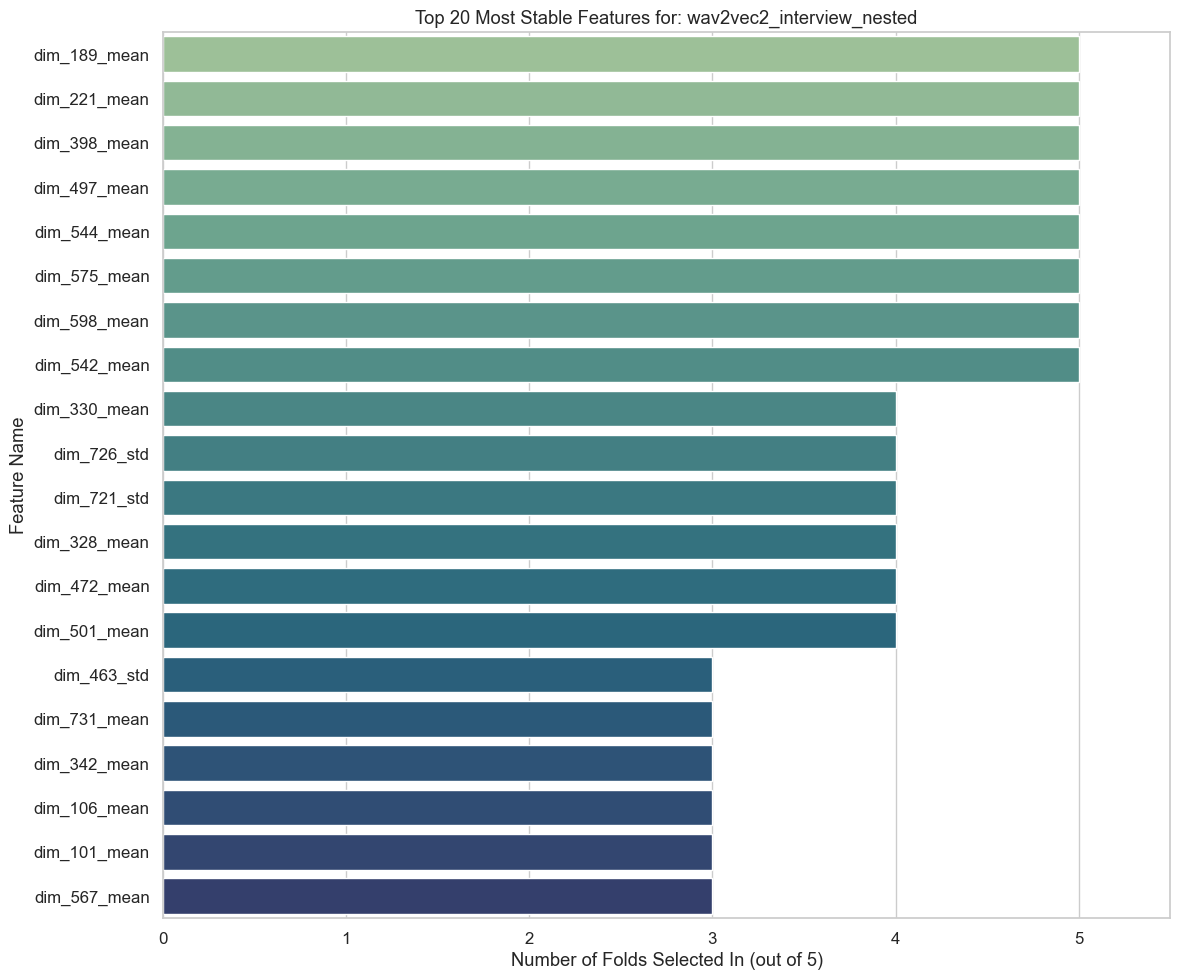

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


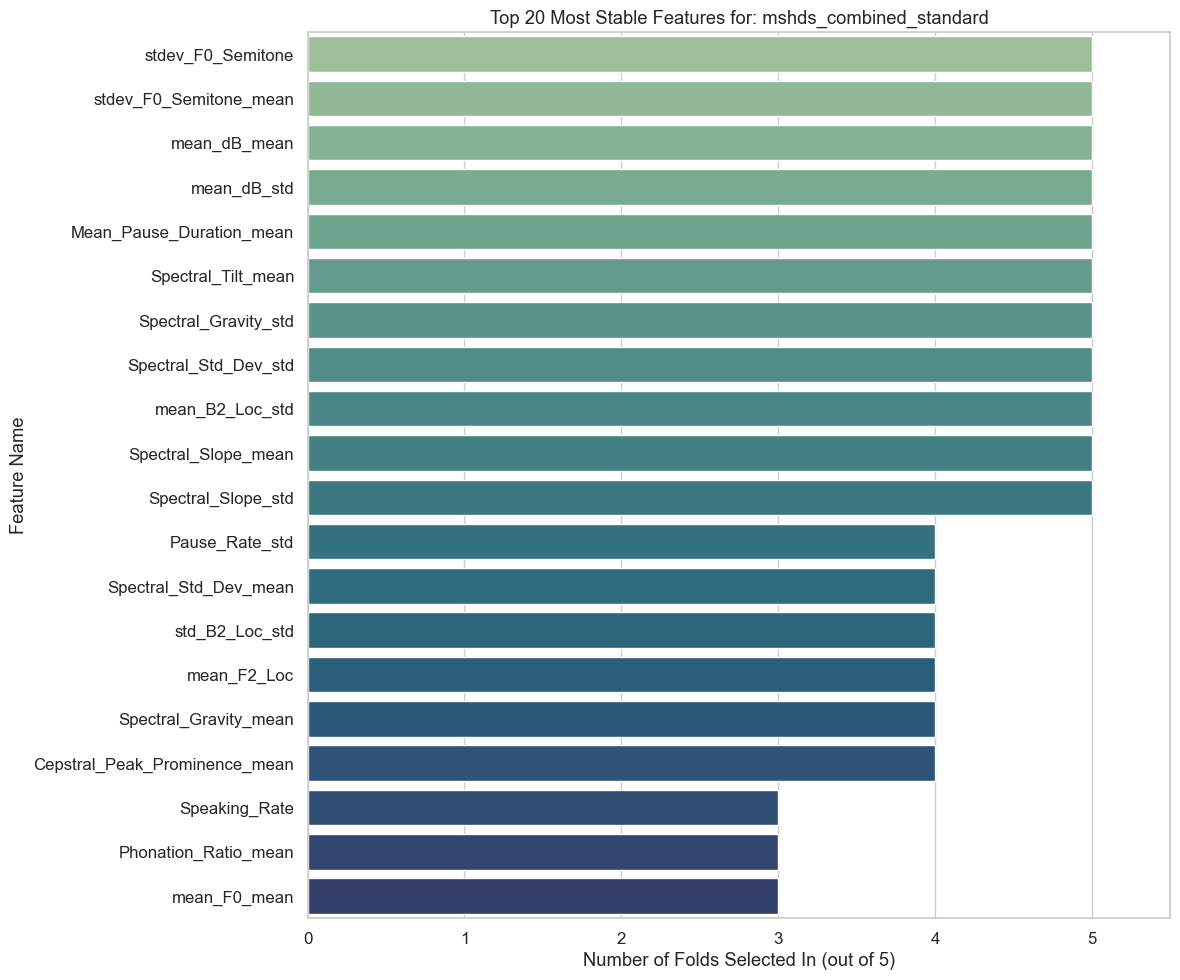

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


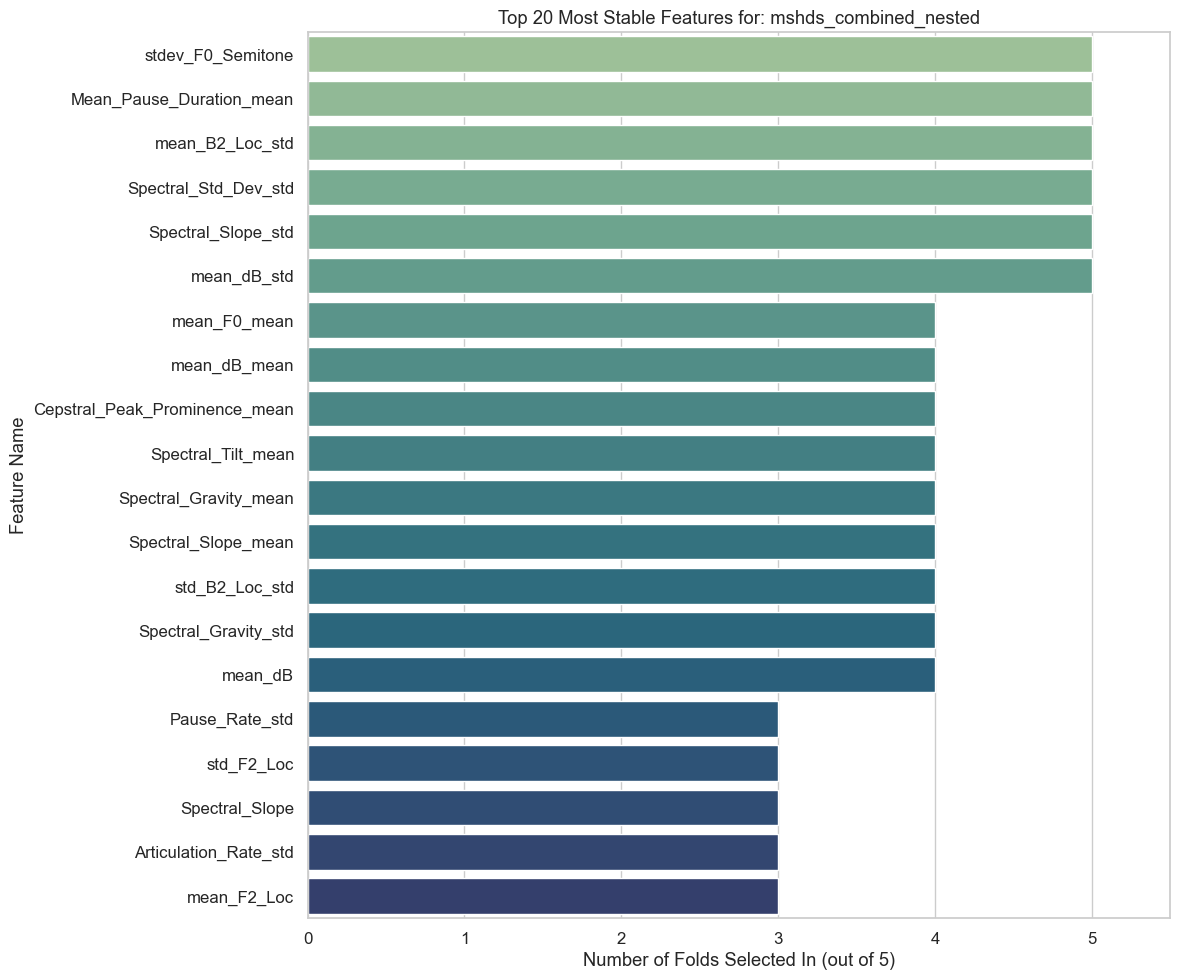

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


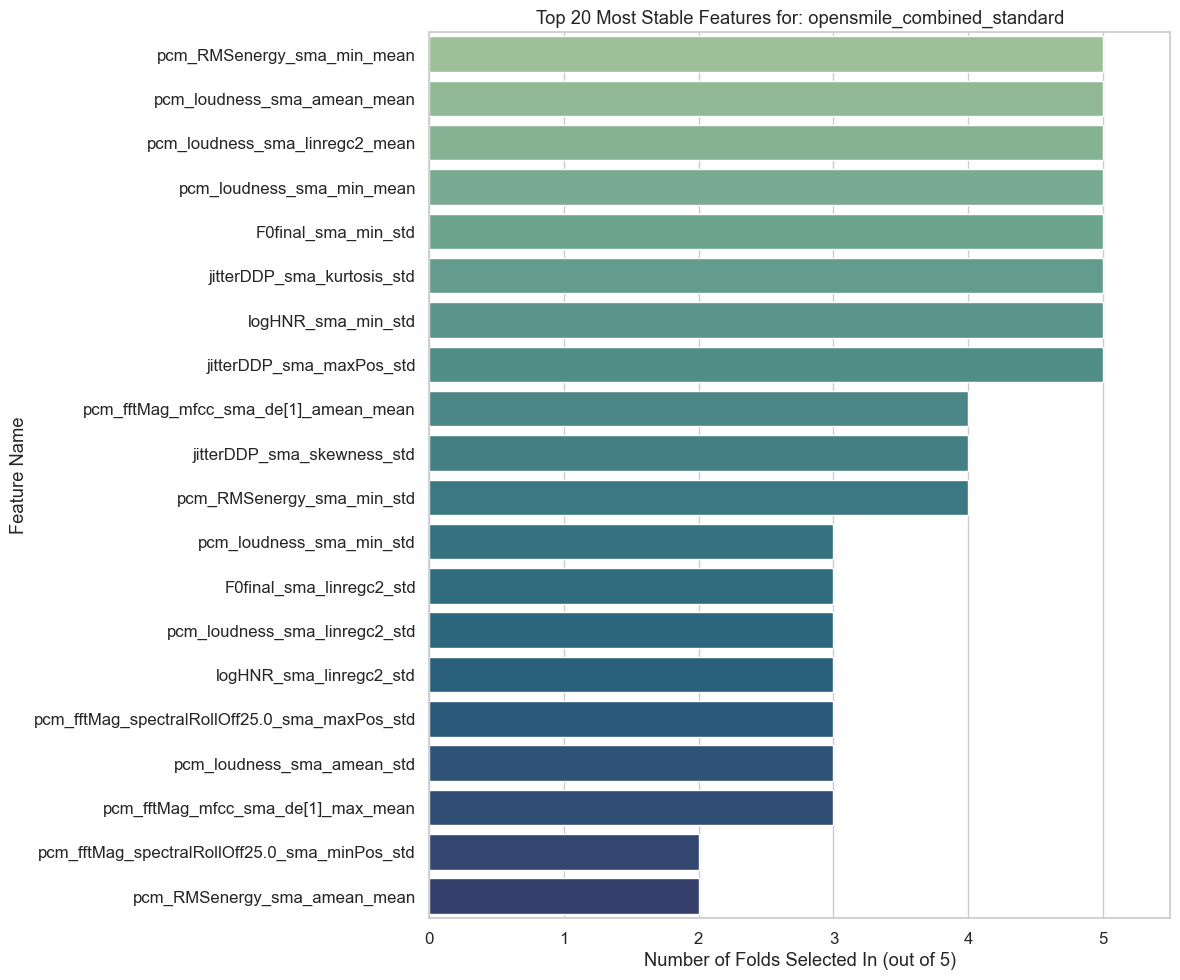

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


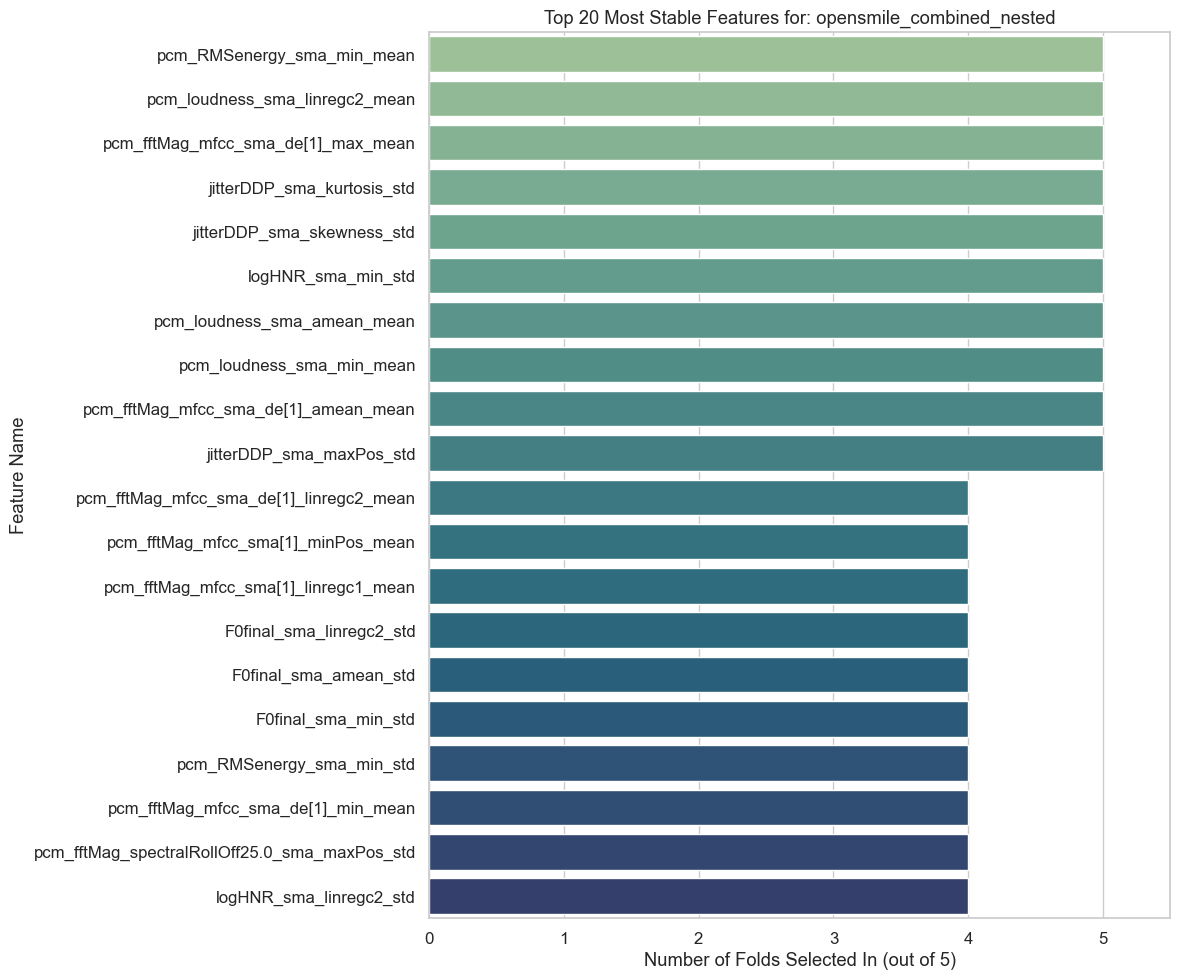

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


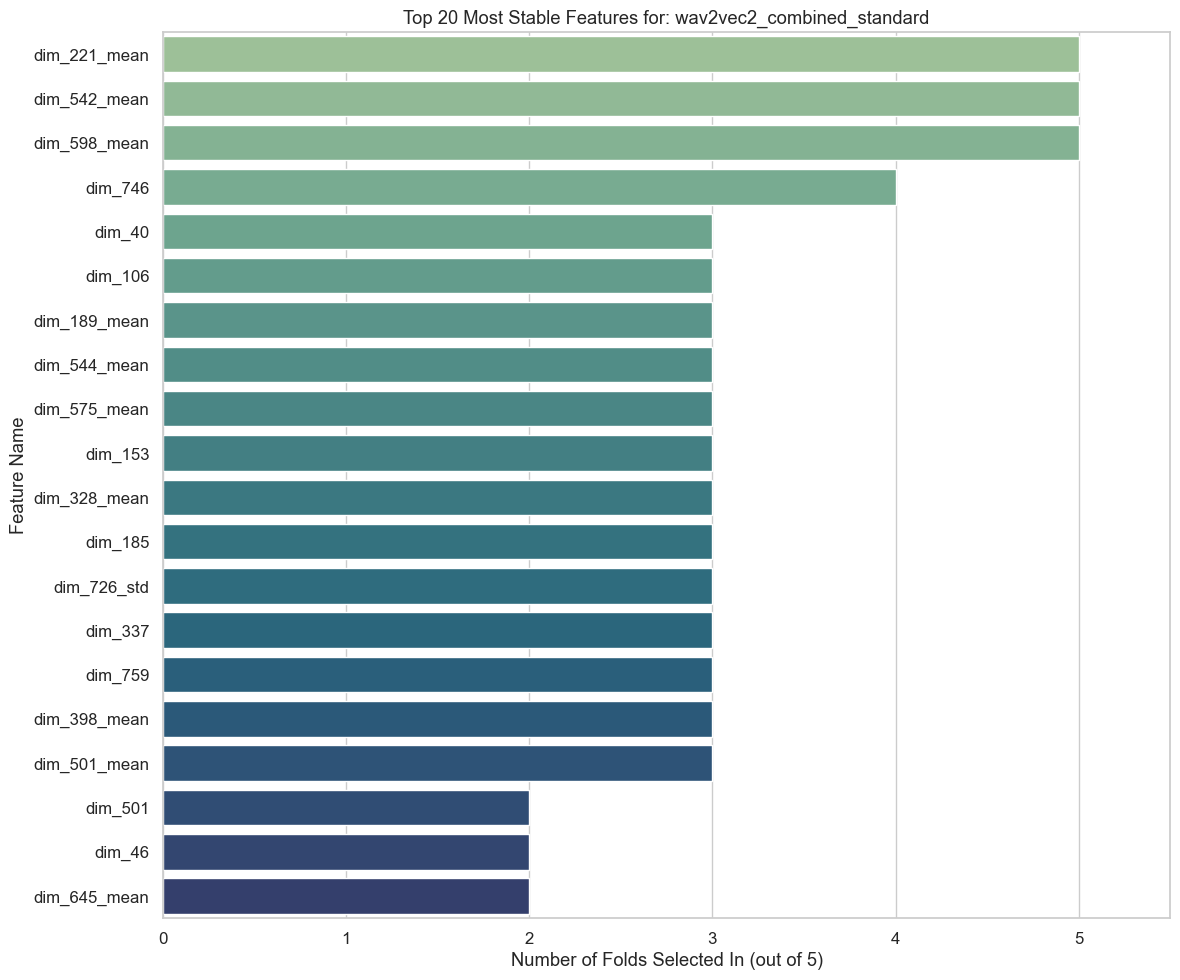

C:\Users\ayush\AppData\Local\Temp\ipykernel_12376\2195714454.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')


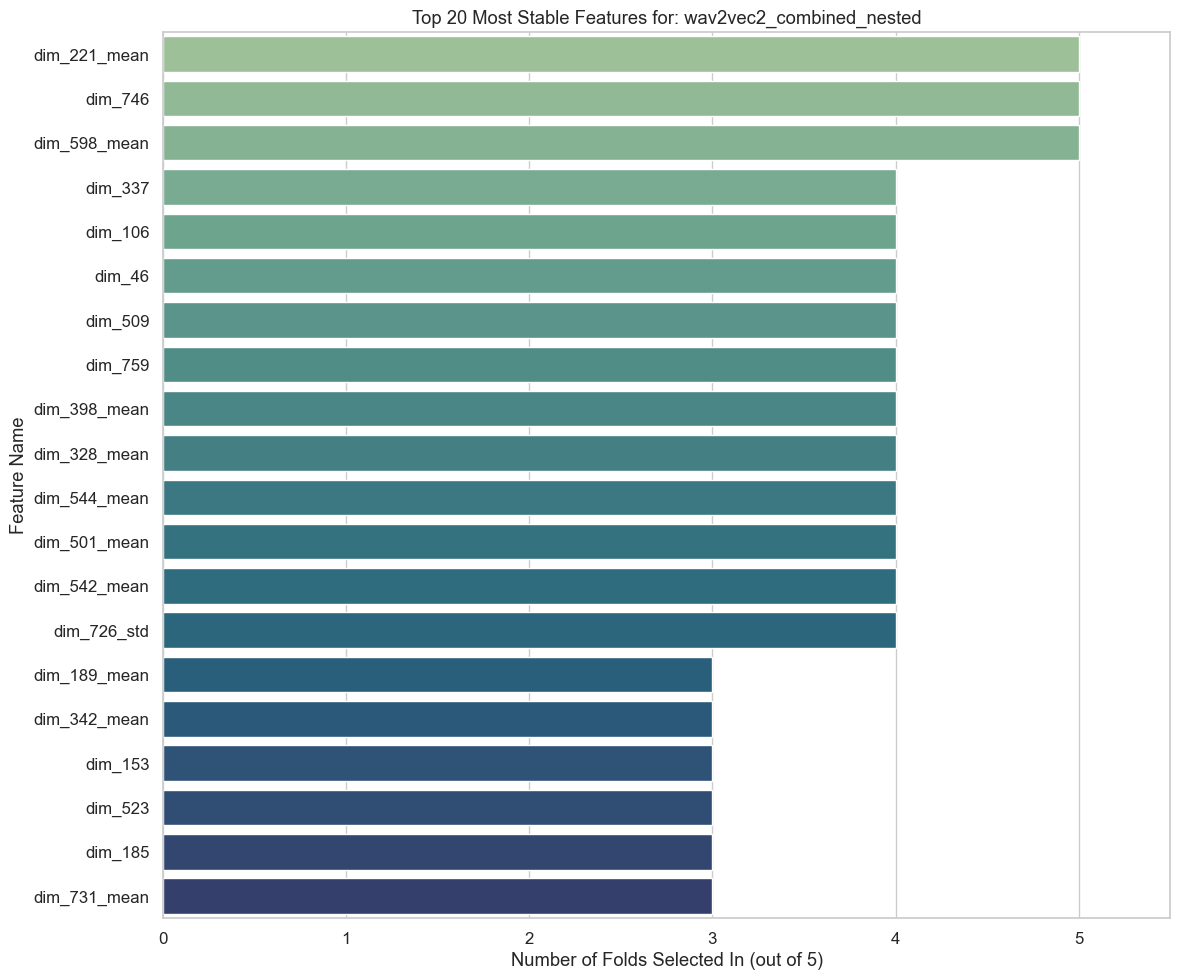

In [9]:
# Analyze and Visualize Feature Stability

def analyze_and_plot_feature_stability(results_df, experiment_name, top_n=20):
    """Counts feature frequencies and plots the top N most stable features."""
    
    all_selected_features = list(itertools.chain.from_iterable(results_df['selected_features']))
    feature_counts = Counter(all_selected_features)
    
    if not feature_counts:
        print(f"No features were selected for experiment: {experiment_name}")
        return
        
    feature_freq_df = pd.DataFrame(feature_counts.items(), columns=['feature', 'count'])
    feature_freq_df = feature_freq_df.sort_values(by='count', ascending=False)
    
    plt.figure(figsize=(12, 10))
    sns.barplot(data=feature_freq_df.head(top_n), x='count', y='feature', palette='crest')
    plt.title(f'Top {top_n} Most Stable Features for: {experiment_name}')
    plt.xlabel('Number of Folds Selected In (out of 5)')
    plt.ylabel('Feature Name')
    plt.xlim(0, 5.5)
    plt.tight_layout()
    plt.show()

# Run the stability analysis for each experiment
for experiment_name, data in all_results.items():
    analyze_and_plot_feature_stability(data['results_df'], experiment_name)

In [ ]:
# Analyze Dataset Class Balance 

# The 'reading_df' should already be loaded
# Use to get the unique participant labels
participant_labels = reading_df[['unique_participant_id', 'label']].drop_duplicates()

print("--- Class Distribution in the Dataset ---")
class_counts = participant_labels['label'].value_counts()
print(class_counts)

# Print as a percentage
print("\nClass Balance:")
print(class_counts / len(participant_labels) * 100)

--- Class Distribution in the Dataset ---
label
Patient    57
Control    54
Name: count, dtype: int64

Class Balance:
label
Patient    51.351351
Control    48.648649
Name: count, dtype: float64
